<font size=6><center> Machine Learning - Assignment 3 </center></font>

<font size=5><center> Unsupervised Learning and Dimensionality Reduction </center></font>

<font size="4"><center>Author: Mohamed Amine DASSOULI </center></font>

<a id='1'></a>
# Importations

In [306]:
import pandas as pd
import numpy as np 
from time import time


from numpy.random import seed


%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

from sklearn.neural_network import MLPClassifier

<a id='2'></a>
# Configuration

In [2]:
PATH_CSV_DATA_1 = "Data/Churn_Modelling.csv"
PATH_CSV_DATA_2 = "Data/Car_Evaluation.txt"

<a id='3'></a>
# Functions

In [3]:
def encode_column(col: np.ndarray, max_unique_values: int = 100) -> np.ndarray:
    """
    Encode a numpy array
    
    Parameters
    ----------
    col : numpy 1D-Array
    max_unique_values : int, default 100
        Limit the number of unique values to use
        Take the most occurents and regroup all the others in one value

    Returns
    -------
    numpy 2D-Array
        Encoded Array
    
    
    """
    # Get the unique values and their frequences in the list
    col_values = np.unique(col, return_counts=True)
    
    # If there are only two unique values, we use a labelencoder, otherwise we use a onehotencoder
    n_unique_values = len(col_values[0]) 
    if n_unique_values <=2 : 
        labelencoder = LabelEncoder()
        encoded_col = labelencoder.fit_transform(col.reshape((len(col), 1)))
    else:
        # Find the `max_unique_values` most occurent unique values in the column
        col_values = [(val,freq) for (val,freq) in zip(col_values[0], col_values[1])]
        col_values.sort(key=lambda x: x[1])
        values_keep = [col_values[i][0] for i in range(min(max_unique_values, n_unique_values))]
        
        # Keep the most occurent unique values, and change all the others to a value "Others"
        col = np.array([value if value in values_keep else "Others" for value in col])
        
        # Use a hot encoder
        onehotencoder = OneHotEncoder()
        encoded_col = onehotencoder.fit_transform(col.reshape((len(col), 1))).toarray()
    
    return encoded_col

<a id='4'></a>
# Visualizing data 1

In [4]:
# Loading data 
df_data1 = pd.read_csv(PATH_CSV_DATA_1, )

# View the dataframe
df_data1.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2     233.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   
5       8  113755.78              2          1               0   
6       7       0.00              2          1               1   
7       4  115046.74              4          1               0   
8       4  142051.07              2          0               1   
9       2  134603.88              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0  
5        149756.71       1  
6         10062.80       0  
7        119346.88       1  
8         74940.50       0  
9         71725.73       0

### Basic information

In [5]:
# Visualize basic information about the data
print(f"- Data shape : {df_data1.shape}\n")
print(f"- Keys :\n\n{df_data1.dtypes}")

- Data shape : (10000, 14)

- Keys :

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


<a id='5'></a>
# Data Preprocessing

In [6]:
Categorical_X = np.concatenate([df_data1.values[:,4:6], df_data1.values[:,10:12]],axis=1) 
# Geography, Gender, HasCrCard and IsActiveMember
print(Categorical_X)

[['France' 'Female' 1 1]
 ['Spain' 'Female' 0 1]
 ['France' 'Female' 1 0]
 ...
 ['France' 'Female' 0 1]
 ['Germany' 'Male' 1 0]
 ['France' 'Female' 1 0]]


In [7]:
Continuous_X = np.concatenate([df_data1.values[:,3:4],df_data1.values[:,6:10],df_data1.values[:,12:13]],axis=1)
# CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary
print(Continuous_X)

[[619 42 2 233.0 1 101348.88]
 [608 41 1 83807.86 1 112542.58]
 [502 42 8 159660.8 3 113931.57]
 ...
 [709 36 7 0.0 1 42085.58]
 [772 42 3 75075.31 2 92888.52]
 [792 28 4 130142.79 1 38190.78]]


In [10]:
Y1 = df_data1.values[:,-1]
# Exited 
print(Y1)

[1 0 1 ... 1 1 0]


In [11]:
labels1 = ["Geography-France", "Geography-Germany", "Geography-Spain", "Gender", "HasCrCard", "IsActiveMember", 
           "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

## <font size="3"> Encoding Categorical data :</font>

In [12]:
# Prepare the features
features = []
for i in range(2):
    col_encoded = encode_column(Categorical_X[:,i], 20)
    features.append(np.reshape(col_encoded, (Categorical_X.shape[0], -1)))

X = np.concatenate((features), axis=1)
Categorical_X= np.concatenate((X, Categorical_X[:,2:]), axis=1)
print(f"Shape of Categorical X : {Categorical_X.shape}")


Shape of Categorical X : (10000, 6)


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## <font size="3"> Encoding Continuous data :</font>

In [13]:
scaler = StandardScaler()
scaled_X  = scaler.fit_transform(Continuous_X)
print(scaled_X[:10,])

[[-0.32622142  0.29351742 -1.04175968 -1.22211429 -0.91158349  0.02188649]
 [-0.44003595  0.19816383 -1.38753759  0.1173497  -0.91158349  0.21653375]
 [-1.53679418  0.29351742  1.03290776  1.33305358  2.52705662  0.2406869 ]
 [ 0.50152063  0.00745665 -1.38753759 -1.22584861  0.80773656 -0.10891792]
 [ 2.06388377  0.38887101 -1.04175968  0.78572789 -0.91158349 -0.36527578]
 [-0.05720525  0.4842246   1.03290776  0.59732849  0.80773656  0.86365029]
 [ 1.77417405  1.05634615  0.68712986 -1.22584861  0.80773656 -1.56548722]
 [-2.84048792 -0.94607926 -0.35020386  0.61801886  4.24637668  0.33485373]
 [-1.54714096  0.4842246  -0.35020386  1.05082039  0.80773656 -0.43732885]
 [ 0.346319   -1.13678644 -1.04175968  0.93146341 -0.91158349 -0.49323048]]


## <font size="3"> Regrouping the data :</font>

In [16]:
X1 = np.concatenate([Categorical_X.astype(float), scaled_X],axis=1)
print(X1[1,:])

[ 0.          0.          1.          0.          0.          1.
 -0.44003595  0.19816383 -1.38753759  0.1173497  -0.91158349  0.21653375]


In [17]:
X1.shape

(10000, 12)

<a id='4'></a>
# Visualizing data 2

In [18]:
headers = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'car']

# Loading data 
df_data2 = pd.read_csv(PATH_CSV_DATA_2, names=headers)

# View the dataframe
df_data2.head(10)

buying  maint doors persons lug_boot safety    car
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc
5  vhigh  vhigh     2       2      med   high  unacc
6  vhigh  vhigh     2       2      big    low  unacc
7  vhigh  vhigh     2       2      big    med  unacc
8  vhigh  vhigh     2       2      big   high  unacc
9  vhigh  vhigh     2       4    small    low  unacc

### Basic information

In [19]:
# Visualize basic information about the data
print(f"- Data shape : {df_data2.shape}\n")
print(f"- Keys :\n\n{df_data2.dtypes}")

- Data shape : (1728, 7)

- Keys :

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
car         object
dtype: object


### Missing data

In [20]:
# Check if there is any missing data 
df_data2.isna().any()

buying      False
maint       False
doors       False
persons     False
lug_boot    False
safety      False
car         False
dtype: bool

<font size="3"> ==> There is not any NaN cell. Therefore, there is no missing data ! </font>

<a id='5'></a>
# Data Preprocessing

<font size="3"> For this dataset, all the features seem to be useful, so we keep all of them.</font>

Let's take a look at the columns <b>'doors' and 'persons'</b> to see how many unique values they have:

In [21]:
df_data2.doors.unique()

array(['2', '3', '4', '5more'], dtype=object)

In [22]:
df_data2.persons.unique()

array(['2', '4', 'more'], dtype=object)

In [23]:
df_data2.buying.unique()

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [24]:
Categorical_X = df_data2.values[:,:-1]

In [133]:
Y2 = df_data2.values[:,-1]

In [134]:
dict_label_ind = {
    "acc": 1,
    "good": 2,
    "unacc": 0,
    "vgood": 2
}

In [135]:
Y2 = [dict_label_ind[label] for label in Y2]

In [28]:
labels2 = ["buying-high", "buying-low", "buying-med", "buying-vhigh", "maint-high", "maint-low", "maint-med", 
           "maint-vhigh", "doors-2", "doors-3", "doors-4", "doors-5more", "persons-2", "persons-4", 
           "persons-more", "lug_boot-big", "lug_boot-med", "lug_boot-small", "safety-high", "safety-low",
           "safety-med"]

## <font size="3"> Encoding Categorical data :</font>

In [29]:
# Prepare the features
features = []
for i in range(6):
    col_encoded = encode_column(Categorical_X[:,i], 20)
    features.append(np.reshape(col_encoded, (Categorical_X.shape[0], -1)))

X2 = np.concatenate((features), axis=1)

print(f"Shape of X : {X.shape}")

Shape of X : (10000, 4)


In [30]:
X2.shape

(1728, 21)

<a id='6'></a>
# Clustering algorithms

<a id='7'></a>
## K-means

## <font size="3"> Metrics per number of clusters :</font>

In [115]:
values_n_clusters = range(1,50)
ssd_values1 = []
sil_values1 = []
times1 = []
ssd_values2 = []
sil_values2 = []
times2 = []

for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(X1)
    ssd_values1.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values1.append(silhouette_score(X1, k_means.labels_, random_state=0))
        
    times1.append(time() - t)
    
    
for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(X2)
    ssd_values2.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values2.append(silhouette_score(X2, k_means.labels_, random_state=0))
        
    times2.append(time()-t)

## <font size="3"> Wall Clock Time:</font>

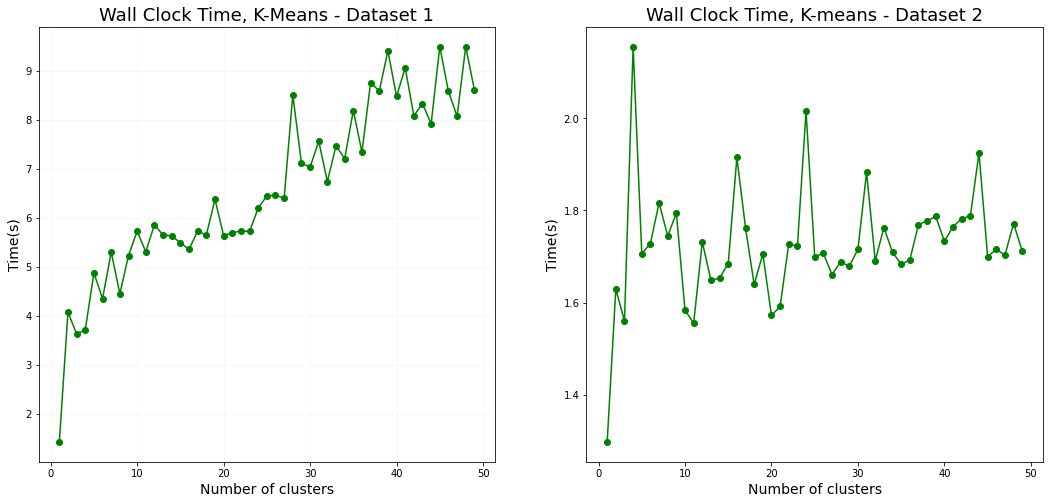

In [147]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_clusters, times1, '-go')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_ylabel('Time(s)', {"fontsize":14})
ax1.set_title("Wall Clock Time, K-Means - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_clusters, times2, '-go')
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.set_ylabel('Time(s)', {"fontsize":14})
ax2.set_title("Wall Clock Time, K-means - Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> Sum of Squared Error:</font>

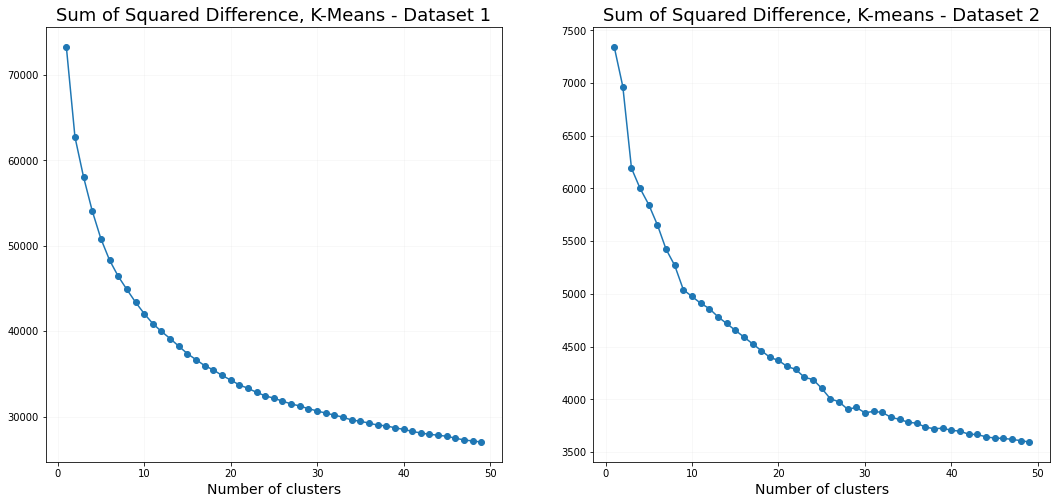

In [148]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_clusters, ssd_values1, '-o')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_title("Sum of Squared Difference, K-Means - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_clusters, ssd_values2, '-o')
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.grid(linestyle='-', alpha=0.1)
ax2.set_title("Sum of Squared Difference, K-means - Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> Silhouette Score:</font>

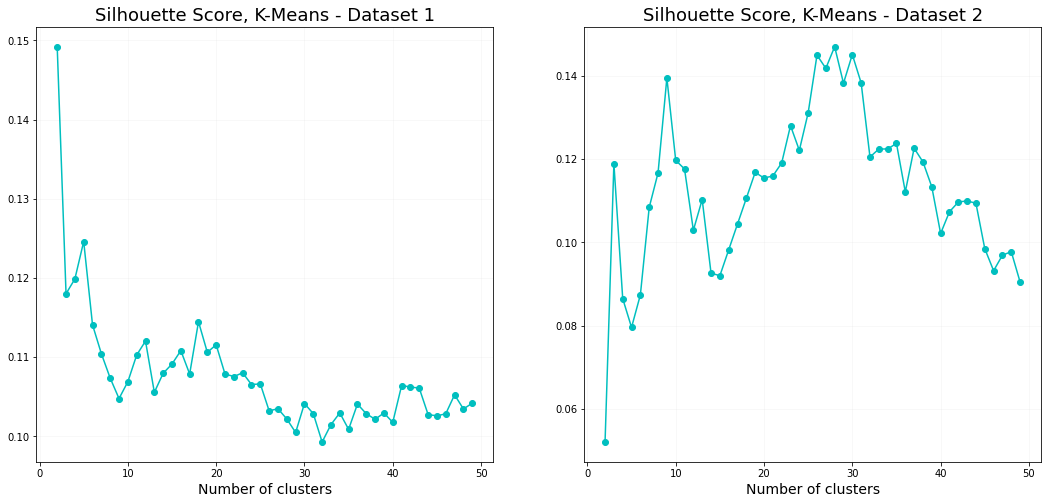

In [149]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_clusters[1:], sil_values1, '-co')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_title("Silhouette Score, K-Means - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_clusters[1:], sil_values2, '-co')
ax2.grid(linestyle='-', alpha=0.1)
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.set_title("Silhouette Score, K-Means - Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> Figure TSNE - Dataset 1:</font>

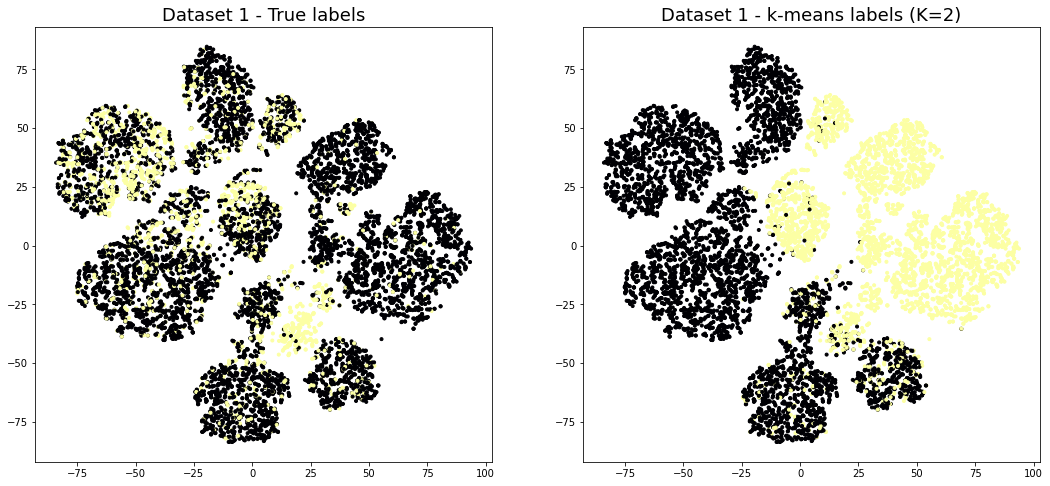

In [152]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=Y1, cmap='inferno', marker='.')
ax1.set_title("Dataset 1 - True labels", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(X1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=[1- label for label in k_means.labels_], cmap='inferno', marker='.')
ax2.set_title("Dataset 1 - k-means labels (K=2)", {"fontsize":18})

plt.show()

## <font size="3"> Figure TSNE - Dataset 2:</font>

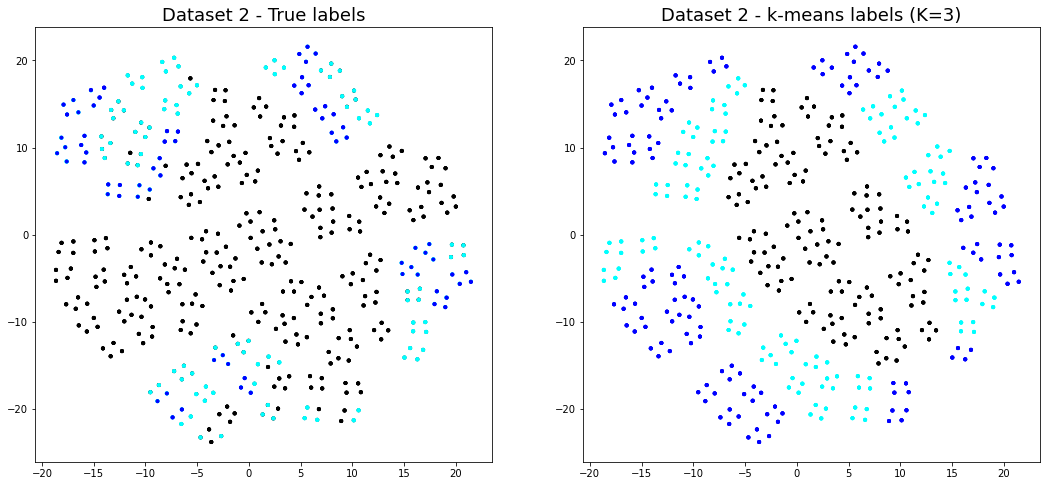

In [153]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    0:'black',
    1:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in Y2], cmap='inferno', marker='.')
ax1.set_title("Dataset 2 - True labels", {"fontsize":18})

dict_colors = {
    2:'black',
    0:'cyan',
    1:'blue'
}

ax2 = fig.add_subplot(1,2,2)
k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(X2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in k_means.labels_], cmap='inferno', marker='.')
ax2.set_title("Dataset 2 - k-means labels (K=3)", {"fontsize":18})

plt.show()

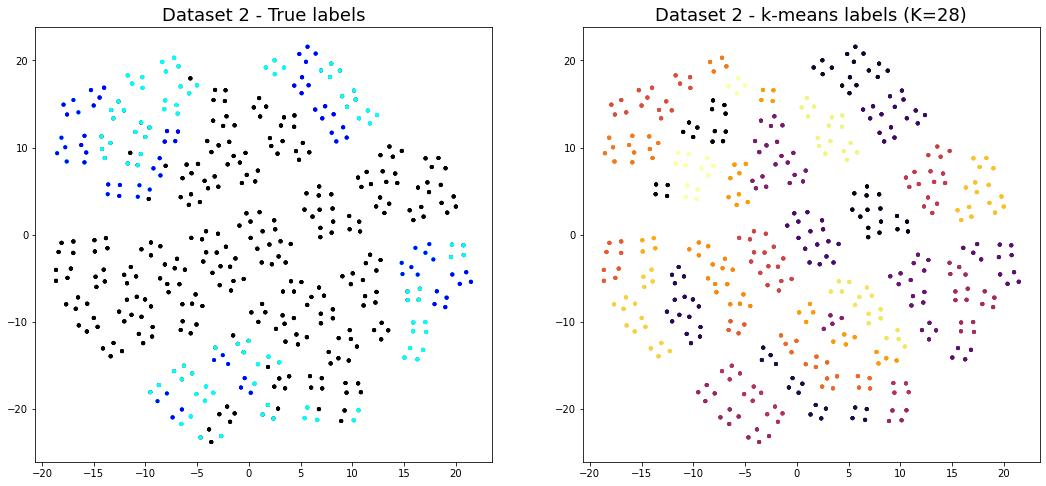

In [154]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    0:'black',
    1:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in Y2], cmap='inferno', marker='.')
ax1.set_title("Dataset 2 - True labels", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
k_means = KMeans(n_clusters=28, random_state=1)
k_means.fit(X2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=k_means.labels_, cmap='inferno', marker='.')
ax2.set_title("Dataset 2 - k-means labels (K=28)", {"fontsize":18})

plt.show()

<a id='7'></a>
## Expectation Maximization

## <font size="3"> Metrics per number of clusters :</font>

In [155]:
values_n_components = range(1, 50)
ssd_values1 = []
sil_values1 = []
times_1 = []
ssd_values2 = []
sil_values2 = []
times_2 = []

for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(X1)
    labels = exp_max.predict(X1)
    s = 0
    for i in range(len(X1)):
        s+=(X1[i] - exp_max.means_[labels[i]])**2
    ssd_values1.append(sum(s))
    
    if n_components != 1:
        sil_values1.append(silhouette_score(X1, labels, random_state=0))
        
    times_1.append(time()-t)
    
for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(X2)
    labels = exp_max.predict(X2)
    s = 0
    for i in range(len(X2)):
        s+=(X2[i] - exp_max.means_[labels[i]])**2
    
    ssd_values2.append(sum(s))
    
    if n_components != 1:
        sil_values2.append(silhouette_score(X2, labels, random_state=0))
        
    times_2.append(time()-t)
    

## <font size="3"> Wall Clock Time:</font>

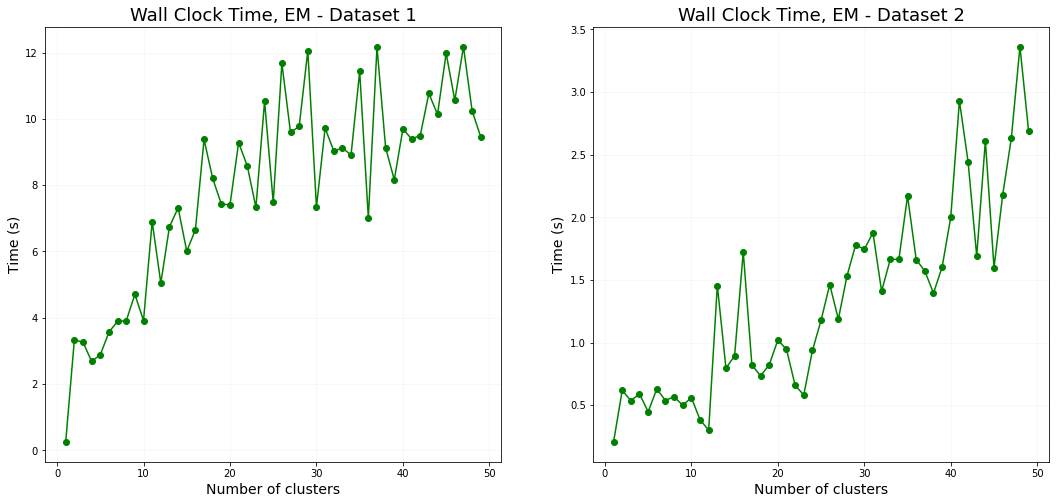

In [162]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_clusters, times_1, '-go')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_ylabel('Time (s)', {"fontsize":14})
ax1.set_title("Wall Clock Time, EM - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_clusters, times_2, '-go')
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.set_ylabel('Time (s)', {"fontsize":14})
ax2.set_title("Wall Clock Time, EM - Dataset 2", {"fontsize":18})
ax2.grid(linestyle='-', alpha=0.1)

plt.show()

## <font size="3"> Sum of Squared Error:</font>

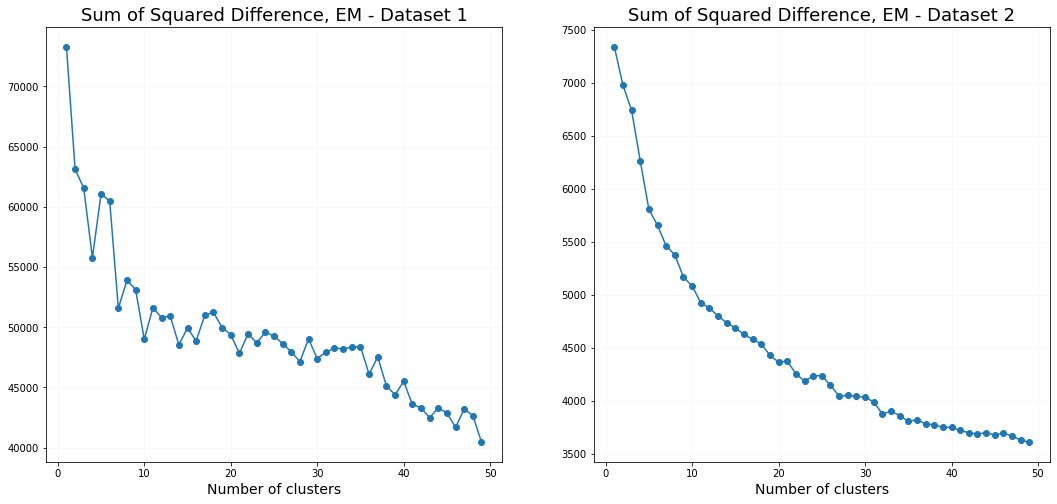

In [158]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_components, ssd_values1, '-o')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_title("Sum of Squared Difference, EM - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_components, ssd_values2, '-o')
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.set_title("Sum of Squared Difference, EM - Dataset 2", {"fontsize":18})
ax2.grid(linestyle='-', alpha=0.1)

plt.show()

## <font size="3"> Silhouette Score:</font>

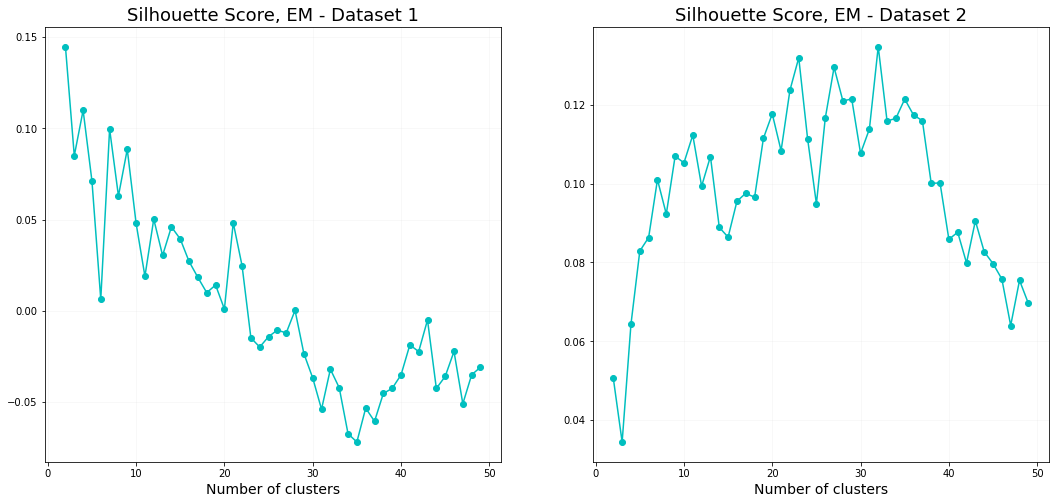

In [160]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(values_n_components[1:], sil_values1, '-co')
ax1.set_xlabel('Number of clusters', {"fontsize":14})
ax1.set_title("Silhouette Score, EM - Dataset 1", {"fontsize":18})
ax1.grid(linestyle='-', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(values_n_components[1:], sil_values2, '-co')
ax2.set_xlabel('Number of clusters', {"fontsize":14})
ax2.set_title("Silhouette Score, EM - Dataset 2", {"fontsize":18})
ax2.grid(linestyle='-', alpha=0.1)


plt.show()

## <font size="3"> Figure TSNE - Dataset 1:</font>

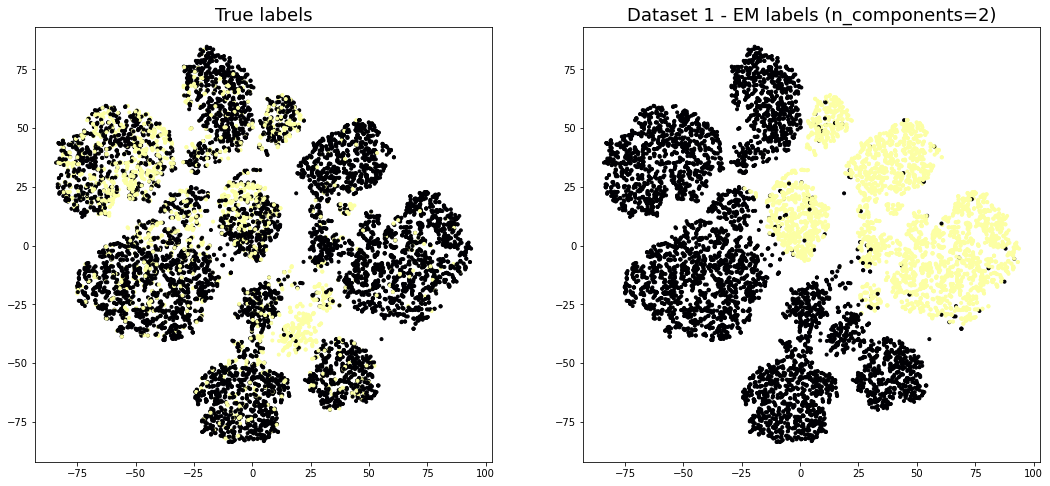

In [161]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=Y1, cmap='inferno', marker='.')
ax1.set_title("True labels", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
exp_max = GaussianMixture(n_components=2, random_state=0)
exp_max.fit(X1)
labels = exp_max.predict(X1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=labels, cmap='inferno', marker='.')
ax2.set_title("Dataset 1 - EM labels (n_components=2)", {"fontsize":18})

plt.show()

## <font size="3"> Figure TSNE - Dataset 2:</font>

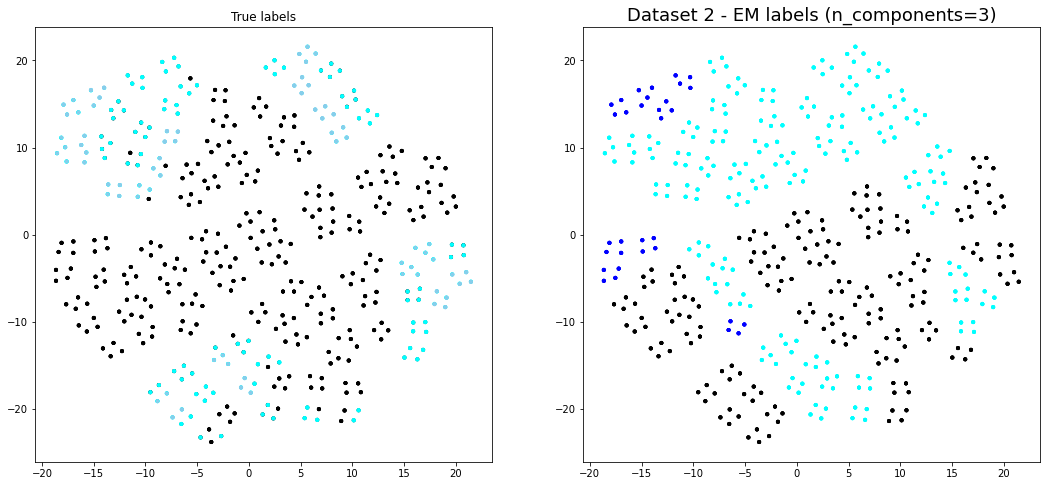

In [165]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    0:'black',
    1:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in Y2], cmap='inferno', marker='.')
ax1.set_title("True labels")


dict_colors = {
    2:'black',
    0:'cyan',
    1:'blue'
}

ax2 = fig.add_subplot(1,2,2)
exp_max = GaussianMixture(n_components=3, random_state=0)
exp_max.fit(X2)
labels = exp_max.predict(X2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels], cmap='inferno', marker='.')
ax2.set_title("Dataset 2 - EM labels (n_components=3)", {"fontsize":18})

plt.show()

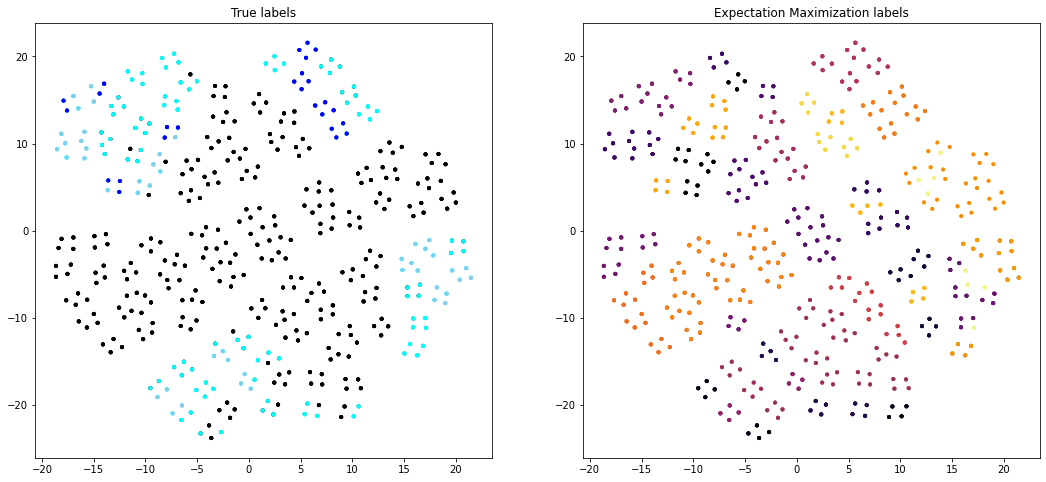

In [57]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    0:'black',
    1:'cyan',
    2:'skyblue',
    3:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in Y2], cmap='inferno', marker='.')
ax1.set_title("True labels")

ax2 = fig.add_subplot(1,2,2)
exp_max = GaussianMixture(n_components=32, random_state=0)
exp_max.fit(X2)
labels = exp_max.predict(X2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=labels, cmap='inferno', marker='.')
ax2.set_title("Expectation Maximization labels")

plt.show()

<a id='6'></a>
# Dimensionality Reduction

## <font size="3"> PCA:</font>

In [201]:
# Dataset 1
pca1 = PCA(n_components=X1.shape[1])
pca1.fit(X1)

# Cumulative variance
cumvar1 = np.cumsum(pca1.explained_variance_ratio_)

# Reconstruction loss
loss1 = []

for k in range(1, X1.shape[1]+1):
    pcaa1 = PCA(k)
    pca1_x1 = pcaa1.fit_transform(X1)
    recons_pca1 = pcaa1.inverse_transform(pca1_x1)
    error = ((recons_pca1 - X1) ** 2).mean()
    loss1.append(error)


# Dataset 2
pca2 = PCA(n_components=X2.shape[1])
pca2.fit(X2)

# Cumulative variance
cumvar2 = np.cumsum(pca2.explained_variance_ratio_)

# Reconstruction loss
loss2 = []

for k in range(1, X2.shape[1]+1):
    pcaa2 = PCA(k)
    pca2_x1 = pcaa2.fit_transform(X2)
    recons_pca1 = pcaa2.inverse_transform(pca2_x1)
    error = ((recons_pca1 - X2) ** 2).mean()
    loss2.append(error)

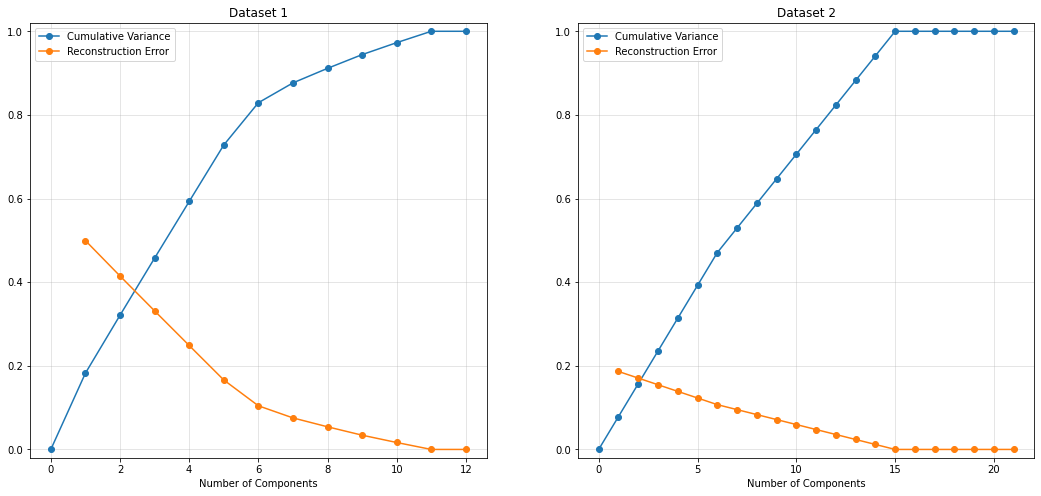

In [202]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
plt.plot(range(X1.shape[1]+1), [0]+list(cumvar1), '-o', label="Cumulative Variance")
plt.plot(range(1,X1.shape[1]+1), loss1, '-o', label="Reconstruction Error")
ax1.set_xlabel("Number of Components")
ax1.set_title("Dataset 1")
ax1.set_ylim(-0.02, 1.02)
ax1.grid(linestyle='-', alpha=0.4)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(range(X2.shape[1]+1), [0]+list(cumvar2), '-o', label="Cumulative Variance")
plt.plot(range(1,X2.shape[1]+1), loss2, '-o', label="Reconstruction Error")
ax2.set_xlabel("Number of Components")
ax2.set_title("Dataset 2")
ax2.set_ylim(-0.02, 1.02)
ax2.grid(linestyle='-', alpha=0.4)
ax2.legend()

plt.show()

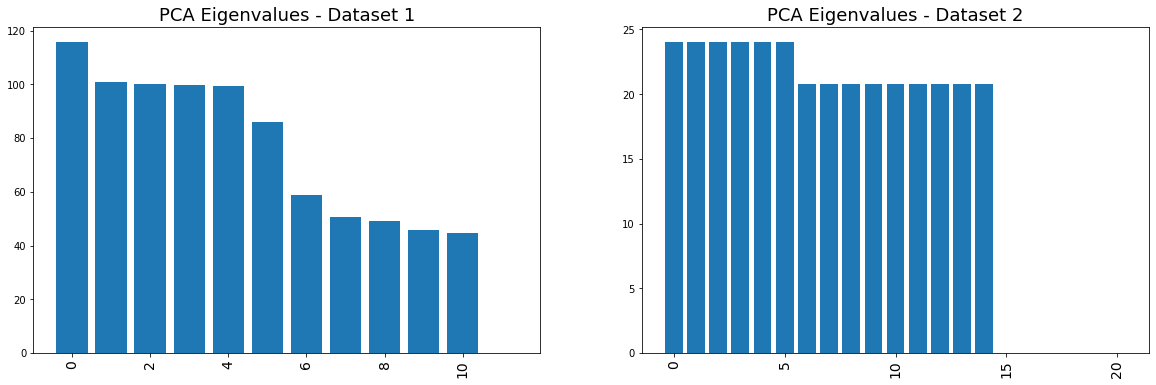

In [215]:
fig = plt.figure(figsize=(20,6))

# Dataset 1
ax1 = fig.add_subplot(1,2,1)
rf1 = RandomForestClassifier(max_depth=12, criterion='entropy')
rf1.fit(X1, Y1.astype(int))
importance1 = rf1.feature_importances_
indices1 = np.argsort(importance1)[::-1]
plt.bar(range(12),pca1.singular_values_)
plt.xticks(rotation='vertical', fontsize=14)
#plt.hlines(0.05, 0, 20)
plt.title("PCA Eigenvalues - Dataset 1", {"fontsize":18})

# Dataset 2
ax2 = fig.add_subplot(1,2,2)
rf2 = RandomForestClassifier(max_depth=10, criterion='entropy')
rf2.fit(X2, Y2)
importance2 = rf2.feature_importances_
indices2 = np.argsort(importance2)[::-1]
plt.bar(range(21),pca2.singular_values_)
plt.xticks(rotation='vertical', fontsize=14)
#plt.hlines(0.04, 0, 20)
plt.title("PCA Eigenvalues - Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> ICA:</font>

In [197]:
kurtosis1 = []
loss1 = []
for k in range(1, X1.shape[1]+1):
    # Kurtosis
    ica = FastICA(n_components=k, random_state=0, max_iter=1000, tol=1e-4)
    ica_x1 = ica.fit_transform(X1)
    kurtosis1.append(pd.DataFrame(ica_x1).kurt(axis=0).abs().mean())
    
    # Reconstruction Error
    recons_ica1 = ica.inverse_transform(ica_x1)
    error = ((recons_ica1 - X1) ** 2).mean()
    loss1.append(error)
    
kurtosis2 = []
loss2 = []
for k in range(1, X2.shape[1]+1):
    # Kurtosis
    ica = FastICA(n_components=k, random_state=0, max_iter=1000, tol=1e-4)
    ica_x2 = ica.fit_transform(X2)
    kurtosis2.append(pd.DataFrame(ica_x2).kurt(axis=0).abs().mean())
    
    # Reconstruction Error
    recons_ica2 = ica.inverse_transform(ica_x2)
    error = ((recons_ica2 - X2) ** 2).mean()
    loss2.append(error)

/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: Convergenc

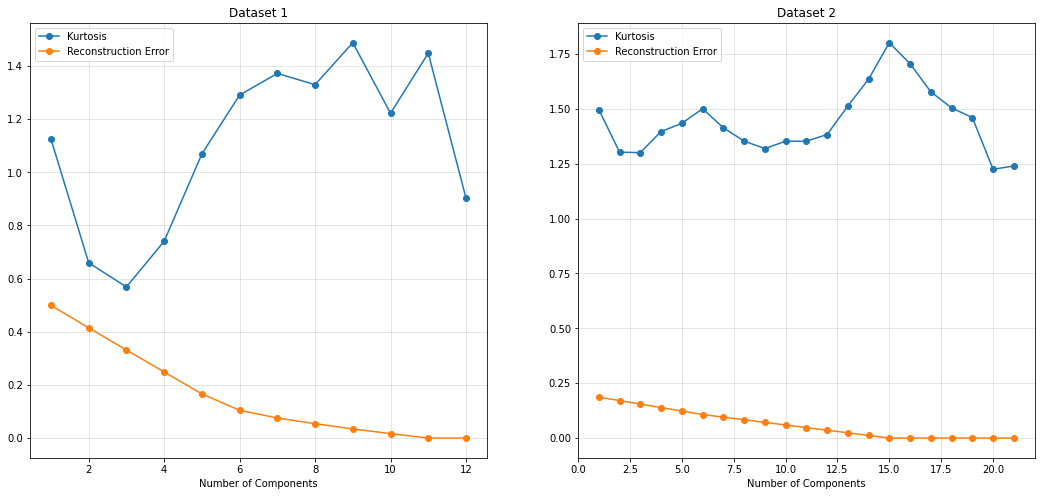

In [200]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
plt.plot(range(1, X1.shape[1]+1), kurtosis1, '-o', label="Kurtosis")
plt.plot(range(1, X1.shape[1]+1), loss1[:11] +[0], '-o', label="Reconstruction Error")
ax1.grid(linestyle='-', alpha=0.4)
ax1.set_xlabel("Number of Components")
ax1.set_title("Dataset 1")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(range(1, X2.shape[1]+1), kurtosis2, '-o', label="Kurtosis")
plt.plot(range(1, X2.shape[1]+1), loss2[:15]+6*[0], '-o', label="Reconstruction Error")
ax2.set_xlabel("Number of Components")
ax2.set_title("Dataset 2")
ax2.grid(linestyle='-', alpha=0.4)
ax2.legend()

plt.show()

## <font size="3"> RP:</font>

In [177]:
loss1 = []
n_try = 100
for k in range(1, X1.shape[1]+1):    
    # Reconstruction Error
    loss_trys = []
    for _ in range(n_try):
        rca = GaussianRandomProjection(n_components=k)
        rca_x1 = rca.fit_transform(X1)
        recons_rca1 = np.dot(rca_x1, rca.components_)  
        error = ((recons_rca1 - X1) ** 2).mean()
        loss_trys.append(error)
    loss1.append(np.mean(loss_trys))
    
loss2 = []
n_try = 100
for k in range(1, X2.shape[1]+1):    
    # Reconstruction Error
    loss_trys = []
    for _ in range(n_try):
        rca = GaussianRandomProjection(n_components=k)
        rca_x2 = rca.fit_transform(X2)
        recons_rca2 = np.dot(rca_x2, rca.components_)  
        error = ((recons_rca2 - X2) ** 2).mean()
        loss_trys.append(error)
    loss2.append(np.mean(loss_trys))

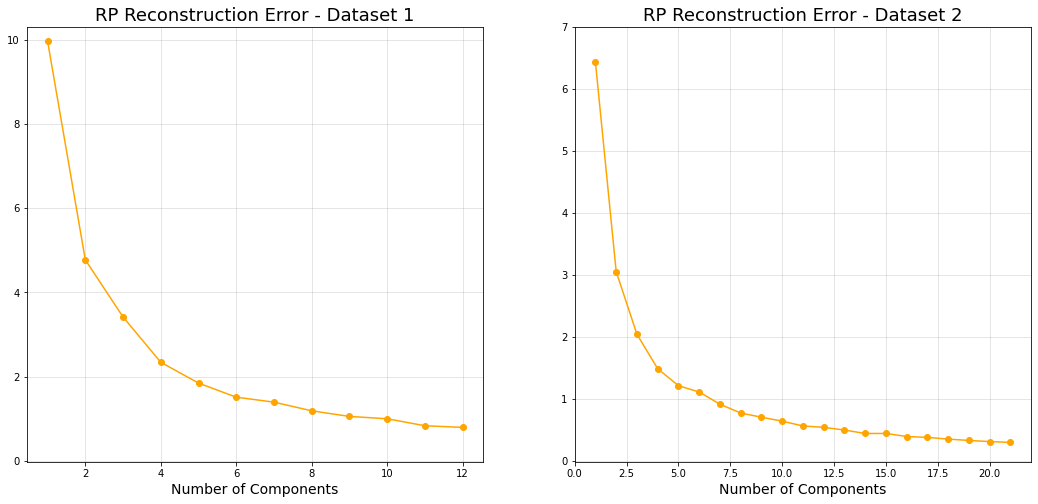

In [185]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
plt.plot(range(1, X1.shape[1]+1), loss1, '-o', label="Reconstruction Error", color="orange")
plt.ylim(-0.02, 10.3)
plt.grid(linestyle='-', alpha=0.4)
ax1.set_xlabel("Number of Components", {"fontsize":14})
ax1.set_title("RP Reconstruction Error - Dataset 1", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
plt.plot(range(1, X2.shape[1]+1), loss2, '-o', label="Reconstruction Error", color="orange")
plt.ylim(-0.02, 7)
plt.grid(linestyle='-', alpha=0.4)
ax2.set_xlabel("Number of Components", {"fontsize":14})
ax2.set_title("RP Reconstruction Error - Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> Random Forest:</font>

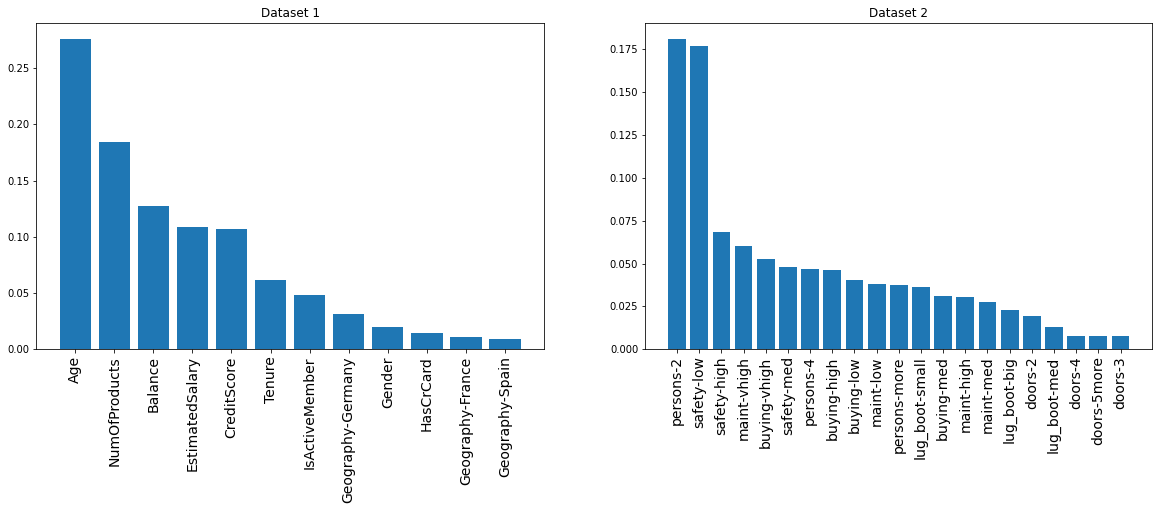

In [193]:
fig = plt.figure(figsize=(20,6))

# Dataset 1
ax1 = fig.add_subplot(1,2,1)
rf1 = RandomForestClassifier(max_depth=12, criterion='entropy')
rf1.fit(X1, Y1.astype(int))
importance1 = rf1.feature_importances_
indices1 = np.argsort(importance1)[::-1]
plt.bar(range(12),importance1[indices1], tick_label=np.array(labels1)[indices1])
plt.xticks(rotation='vertical', fontsize=14)
#plt.hlines(0.05, 0, 20)
plt.title("Dataset 1")

# Dataset 2
ax2 = fig.add_subplot(1,2,2)
rf2 = RandomForestClassifier(max_depth=10, criterion='entropy')
rf2.fit(X2, Y2)
importance2 = rf2.feature_importances_
indices2 = np.argsort(importance2)[::-1]
plt.bar(range(21),importance2[indices2], tick_label=np.array(labels2)[indices2])
plt.xticks(rotation='vertical', fontsize=14)
#plt.hlines(0.04, 0, 20)
plt.title("Dataset 2")

plt.show()

In [194]:
importance2[indices2]

array([0.18115017, 0.17688071, 0.06838346, 0.06003336, 0.05263648,
       0.04797122, 0.04653814, 0.04598708, 0.04033875, 0.03815178,
       0.0377741 , 0.03611391, 0.0308304 , 0.03066875, 0.02768597,
       0.02305913, 0.01957754, 0.0129435 , 0.00781205, 0.00780017,
       0.00766333])

In [195]:
importance1[indices1]

array([0.27627213, 0.18474836, 0.12710886, 0.10915064, 0.10707592,
       0.06170219, 0.04836799, 0.03140711, 0.01999926, 0.01405535,
       0.01055243, 0.00955976])

<a id='6'></a>
#  Clustering on Dimensionally Reduced Datasets

## <font size="3"> PCA/K-means+EM:</font>

In [525]:
# Dataset 1
pca1 = PCA(6)
pca1_X1 = pca1.fit_transform(X1)

# Dataset 2
pca2 = PCA(12)
pca2_X2 = pca2.fit_transform(X2)


values_n_clusters = range(1, 20)
ssd_values1_pca_km = []
sil_values1_pca_km = []
times1_pca_km = []
#ssd_values2_pca_km = []
#sil_values2_pca_km = []
#times2_pca_km = []

for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(pca1_X1)
    times1_pca_km.append(time() - t)
    ssd_values1_pca_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values1_pca_km.append(silhouette_score(pca1_X1, k_means.labels_, random_state=0))
        

k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(pca1_X1)    
labels1_pca_km = k_means.labels_.copy()
    
"""   
for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(pca2_X2)
    ssd_values2_pca_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values2_pca_km.append(silhouette_score(pca2_X2, k_means.labels_, random_state=0))
        
    times2_pca_km.append(time()-t)
    
k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(pca2_X2)    
labels2_pca_km = k_means.labels_.copy()    
    
    
values_n_components = range(1, 20)
ssd_values1_pca_em = []
sil_values1_pca_em = []
times_1_pca_em = []
ssd_values2_pca_em = []
sil_values2_pca_em = []
times_2_pca_em = []

for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(pca1_X1)
    labels = exp_max.predict(pca1_X1)
    
    if n_components == 2:
        labels1_pca_em = labels.copy()
    
    s = 0
    for i in range(len(pca1_X1)):
        s+=(pca1_X1[i] - exp_max.means_[labels[i]])**2
    ssd_values1_pca_em.append(sum(s))
    
    if n_components != 1:
        sil_values1_pca_em.append(silhouette_score(pca1_X1, labels, random_state=0))
        
    times_1_pca_em.append(time()-t) 
    
    
for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(pca2_X2)
    labels = exp_max.predict(pca2_X2)
    
    if n_components == 3:
        labels2_pca_em = labels.copy()
    
    s = 0
    for i in range(len(pca2_X2)):
        s+=(pca2_X2[i] - exp_max.means_[labels[i]])**2
    
    ssd_values2_pca_em.append(sum(s))
    
    if n_components != 1:
        sil_values2_pca_em.append(silhouette_score(pca2_X2, labels, random_state=0))
        
    times_2_pca_em.append(time()-t)
    
""" 

'   \nfor n_clusters in values_n_clusters:\n    t = time()\n    k_means = KMeans(n_clusters=n_clusters, random_state=1)\n    k_means.fit(pca2_X2)\n    ssd_values2_pca_km.append(k_means.inertia_)\n    \n    if n_clusters != 1:\n        sil_values2_pca_km.append(silhouette_score(pca2_X2, k_means.labels_, random_state=0))\n        \n    times2_pca_km.append(time()-t)\n    \nk_means = KMeans(n_clusters=3, random_state=1)\nk_means.fit(pca2_X2)    \nlabels2_pca_km = k_means.labels_.copy()    \n    \n    \nvalues_n_components = range(1, 20)\nssd_values1_pca_em = []\nsil_values1_pca_em = []\ntimes_1_pca_em = []\nssd_values2_pca_em = []\nsil_values2_pca_em = []\ntimes_2_pca_em = []\n\nfor n_components in values_n_components:\n    t = time()\n    exp_max = GaussianMixture(n_components=n_components, random_state=0)\n    exp_max.fit(pca1_X1)\n    labels = exp_max.predict(pca1_X1)\n    \n    if n_components == 2:\n        labels1_pca_em = labels.copy()\n    \n    s = 0\n    for i in range(len(pca1_

In [526]:
times1_pca_km

[1.421027660369873,
 1.5665724277496338,
 1.750901460647583,
 1.7402491569519043,
 1.690244197845459,
 1.9488105773925781,
 1.989288091659546,
 2.222372055053711,
 3.5763957500457764,
 2.3319551944732666,
 2.1036906242370605,
 2.1898789405822754,
 2.583660364151001,
 2.8414053916931152,
 3.067258358001709,
 2.1584746837615967,
 3.3385913372039795,
 2.608609914779663,
 5.427289724349976]

## <font size="3"> ICA/K-means+EM:</font>

In [226]:
# Dataset 1
ica1 = FastICA(n_components=9, random_state=0, max_iter=1000, tol=1e-4)
ica1_X1 = ica1.fit_transform(X1)

# Dataset 2
ica2 = FastICA(n_components=15, random_state=0, max_iter=1000, tol=1e-4)
ica2_X2 = ica2.fit_transform(X2)

values_n_clusters = range(1, 20)
ssd_values1_ica_km = []
sil_values1_ica_km = []
times1_ica_km = []
ssd_values2_ica_km = []
sil_values2_ica_km = []
times2_ica_km = []

for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(ica1_X1)
    ssd_values1_ica_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values1_ica_km.append(silhouette_score(ica1_X1, k_means.labels_, random_state=0))
        
    times1_ica_km.append(time() - t)

k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(ica1_X1)    
labels1_ica_km = k_means.labels_.copy()
    
for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(ica2_X2)
    ssd_values2_ica_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values2_ica_km.append(silhouette_score(ica2_X2, k_means.labels_, random_state=0))
        
    times2_ica_km.append(time()-t)
    
k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(ica2_X2)    
labels2_ica_km = k_means.labels_.copy()

    
values_n_components = range(1, 20)
ssd_values1_ica_em = []
sil_values1_ica_em = []
times_1_ica_em = []
ssd_values2_ica_em = []
sil_values2_ica_em = []
times_2_ica_em = []

for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(ica1_X1)
    labels = exp_max.predict(ica1_X1)
    
    if n_components == 2:
        labels1_ica_em = labels.copy()
    
    s = 0
    for i in range(len(ica1_X1)):
        s+=(ica1_X1[i] - exp_max.means_[labels[i]])**2
    ssd_values1_ica_em.append(sum(s))
    
    if n_components != 1:
        sil_values1_ica_em.append(silhouette_score(ica1_X1, labels, random_state=0))
        
    times_1_ica_em.append(time()-t)
    
for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(ica2_X2)
    labels = exp_max.predict(ica2_X2)
    
    if n_components == 3:
        labels2_ica_em = labels.copy()
    
    s = 0
    for i in range(len(ica2_X2)):
        s+=(ica2_X2[i] - exp_max.means_[labels[i]])**2
    
    ssd_values2_ica_em.append(sum(s))
    
    if n_components != 1:
        sil_values2_ica_em.append(silhouette_score(ica2_X2, labels, random_state=0))
        
    times_2_ica_em.append(time()-t)

## <font size="3"> RP/K-means+EM:</font>

In [227]:
# Dataset 1
rca1 = GaussianRandomProjection(n_components=5)
rca1_X1 = rca1.fit_transform(X1)

# Dataset 2
rca2 = GaussianRandomProjection(n_components=7)
rca2_X2 = rca2.fit_transform(X2)

values_n_clusters = range(1, 20)
ssd_values1_rca_km = []
sil_values1_rca_km = []
times1_rca_km = []
ssd_values2_rca_km = []
sil_values2_rca_km = []
times2_rca_km = []

for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(rca1_X1)
    ssd_values1_rca_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values1_rca_km.append(silhouette_score(rca1_X1, k_means.labels_, random_state=0))
        
    times1_rca_km.append(time() - t)

k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(rca1_X1)    
labels1_rca_km = k_means.labels_.copy()
    
for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(rca2_X2)
    ssd_values2_rca_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values2_rca_km.append(silhouette_score(rca2_X2, k_means.labels_, random_state=0))
        
    times2_rca_km.append(time()-t)
    
k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(rca2_X2)    
labels2_rca_km = k_means.labels_.copy()

    
values_n_components = range(1, 20)
ssd_values1_rca_em = []
sil_values1_rca_em = []
times_1_rca_em = []
ssd_values2_rca_em = []
sil_values2_rca_em = []
times_2_rca_em = []

for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(rca1_X1)
    labels = exp_max.predict(rca1_X1)
    
    if n_components == 2:
        labels1_rca_em = labels.copy()
    
    s = 0
    for i in range(len(rca1_X1)):
        s+=(rca1_X1[i] - exp_max.means_[labels[i]])**2
    ssd_values1_rca_em.append(sum(s))
    
    if n_components != 1:
        sil_values1_rca_em.append(silhouette_score(rca1_X1, labels, random_state=0))
        
    times_1_rca_em.append(time()-t)
    
for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(rca2_X2)
    labels = exp_max.predict(rca2_X2)
    
    if n_components == 3:
        labels2_rca_em = labels.copy()
    
    s = 0
    for i in range(len(rca2_X2)):
        s+=(rca2_X2[i] - exp_max.means_[labels[i]])**2
    
    ssd_values2_rca_em.append(sum(s))
    
    if n_components != 1:
        sil_values2_rca_em.append(silhouette_score(rca2_X2, labels, random_state=0))
        
    times_2_rca_em.append(time()-t)

## <font size="3"> RF/K-means+EM:</font>

In [255]:
# Dataset 1
rf1_X1 = X1[:, indices1[importance1[indices1]>0.05]]


# Dataset 2
rf2_X2 = X2[:, indices2[importance2[indices2]>0.04]]

values_n_clusters = range(1, 20)
ssd_values1_rf_km = []
sil_values1_rf_km = []
times1_rf_km = []
ssd_values2_rf_km = []
sil_values2_rf_km = []
times2_rf_km = []

for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(rf1_X1)
    ssd_values1_rf_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values1_rf_km.append(silhouette_score(rf1_X1, k_means.labels_, random_state=0))
        
    times1_rf_km.append(time() - t)

k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(rf1_X1)    
labels1_rf_km = k_means.labels_.copy()
    
for n_clusters in values_n_clusters:
    t = time()
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(rf2_X2)
    ssd_values2_rf_km.append(k_means.inertia_)
    
    if n_clusters != 1:
        sil_values2_rf_km.append(silhouette_score(rf2_X2, k_means.labels_, random_state=0))
        
    times2_rf_km.append(time()-t)

k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(rf2_X2)    
labels2_rf_km = k_means.labels_.copy()    
    
values_n_components = range(1, 20)
ssd_values1_rf_em = []
sil_values1_rf_em = []
times_1_rf_em = []
ssd_values2_rf_em = []
sil_values2_rf_em = []
times_2_rf_em = []

for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(rf1_X1)
    labels = exp_max.predict(rf1_X1)
    
    if n_components == 2:
        labels1_rf_em = labels.copy()
    
    s = 0
    for i in range(len(rf1_X1)):
        s+=(rf1_X1[i] - exp_max.means_[labels[i]])**2
    ssd_values1_rf_em.append(sum(s))
    
    if n_components != 1:
        sil_values1_rf_em.append(silhouette_score(rf1_X1, labels, random_state=0))
        
    times_1_rf_em.append(time()-t)
    
for n_components in values_n_components:
    t = time()
    exp_max = GaussianMixture(n_components=n_components, random_state=0)
    exp_max.fit(rf2_X2)
    labels = exp_max.predict(rf2_X2)
    
    if n_components == 3:
        labels2_rf_em = labels.copy()
    
    s = 0
    for i in range(len(rf2_X2)):
        s+=(rf2_X2[i] - exp_max.means_[labels[i]])**2
    
    ssd_values2_rf_em.append(sum(s))
    
    if n_components != 1:
        sil_values2_rf_em.append(silhouette_score(rf2_X2, labels, random_state=0))
        
    times_2_rf_em.append(time()-t)

## <font size="3"> Representation of clusters:</font>

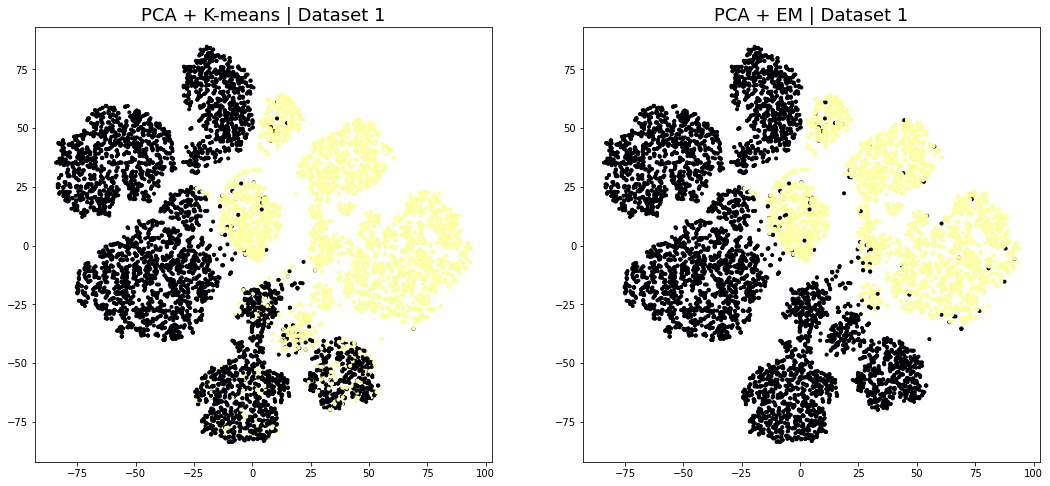

In [225]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_pca_km], cmap='inferno', marker='.')
ax1.set_title("PCA + K-means | Dataset 1", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_pca_em], cmap='inferno', marker='.')
ax2.set_title("PCA + EM | Dataset 1", {"fontsize":18})

plt.show()

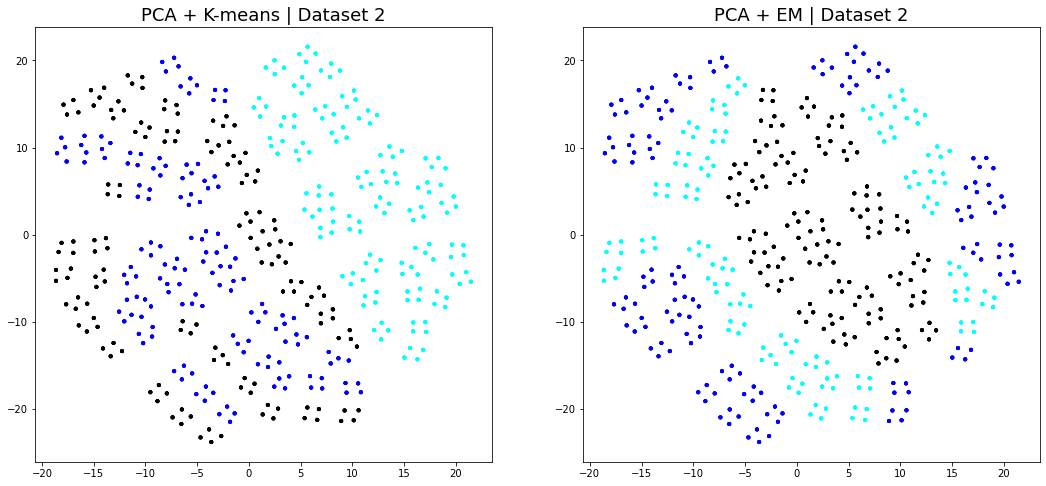

In [223]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    1:'black',
    0:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_pca_km], cmap='inferno', marker='.')
ax1.set_title("PCA + K-means | Dataset 2", {"fontsize":18})


dict_colors = {
    1:'black',
    0:'cyan',
    2:'blue'
}

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_pca_em], cmap='inferno', marker='.')
ax2.set_title("PCA + EM | Dataset 2", {"fontsize":18})

plt.show()

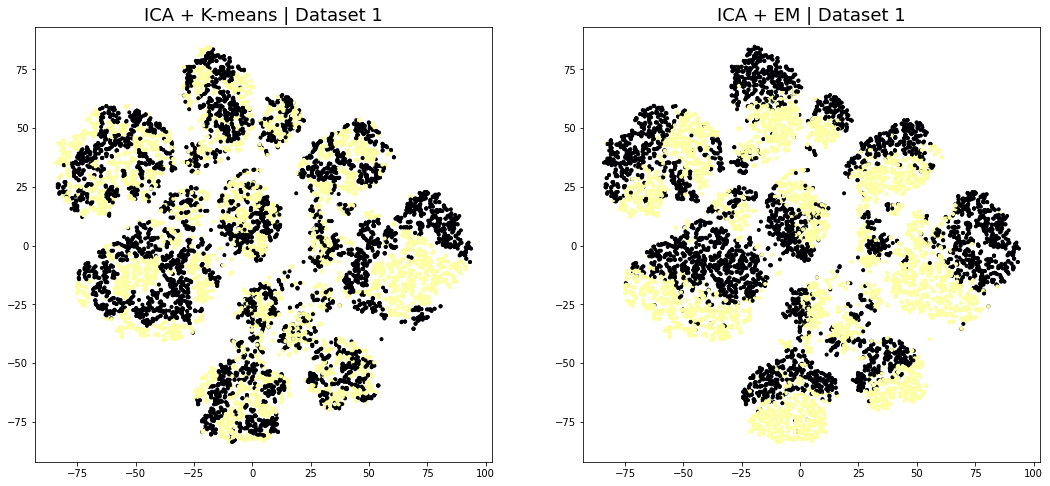

In [243]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
if sum(labels1_ica_km) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_ica_km], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_ica_km], cmap='inferno', marker='.')
ax1.set_title("ICA + K-means | Dataset 1", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)

if sum(labels1_ica_em) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_ica_em], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_ica_em], cmap='inferno', marker='.')

ax2.set_title("ICA + EM | Dataset 1", {"fontsize":18})

plt.show()

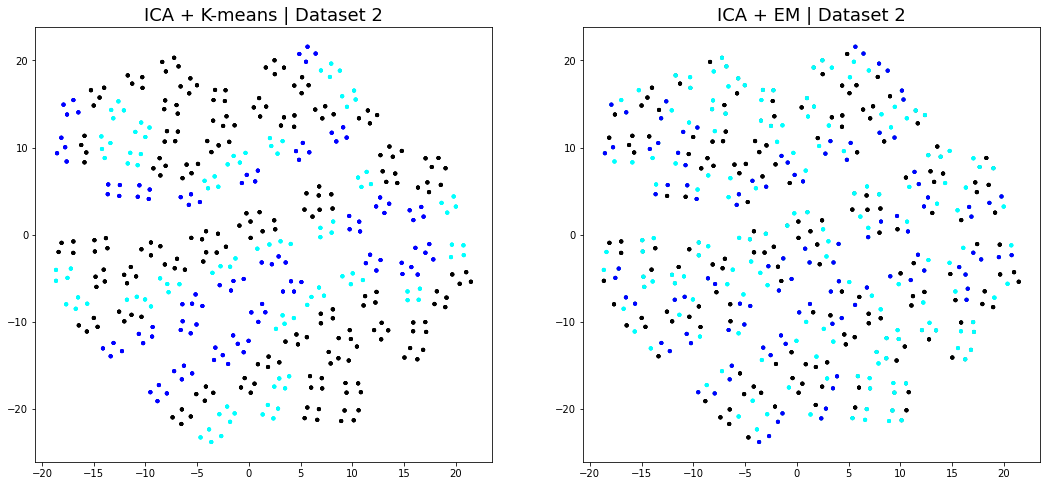

In [253]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    1:'black',
    0:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_ica_km], cmap='inferno', marker='.')
ax1.set_title("ICA + K-means | Dataset 2", {"fontsize":18})


dict_colors = {
    2:'black',
    1:'cyan',
    0:'blue'
}

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_ica_em], cmap='inferno', marker='.')
ax2.set_title("ICA + EM | Dataset 2", {"fontsize":18})

plt.show()

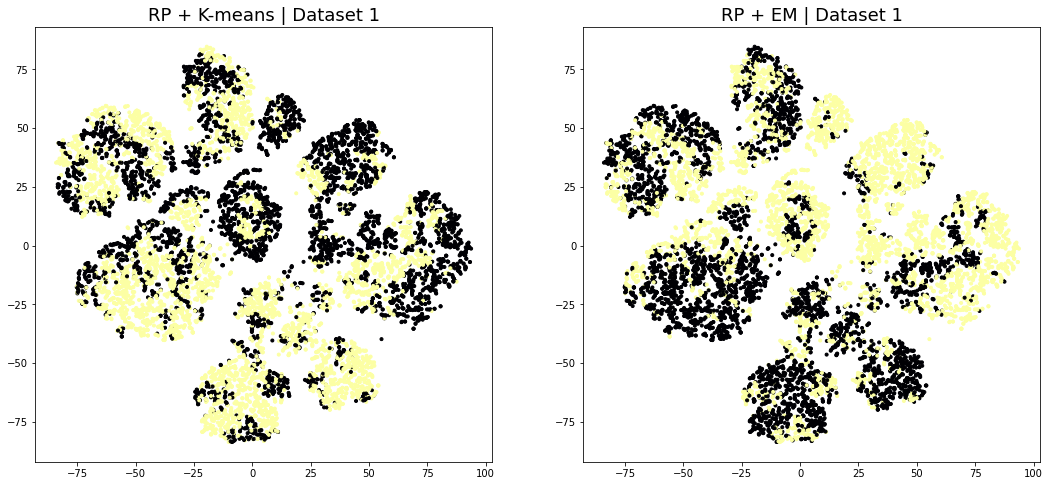

In [265]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
if sum(labels1_rca_km) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_rca_km], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_rca_km], cmap='inferno', marker='.')
ax1.set_title("RP + K-means | Dataset 1", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)

if sum(labels1_rca_em) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_rca_em], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_rca_em], cmap='inferno', marker='.')

ax2.set_title("RP + EM | Dataset 1", {"fontsize":18})

plt.show()

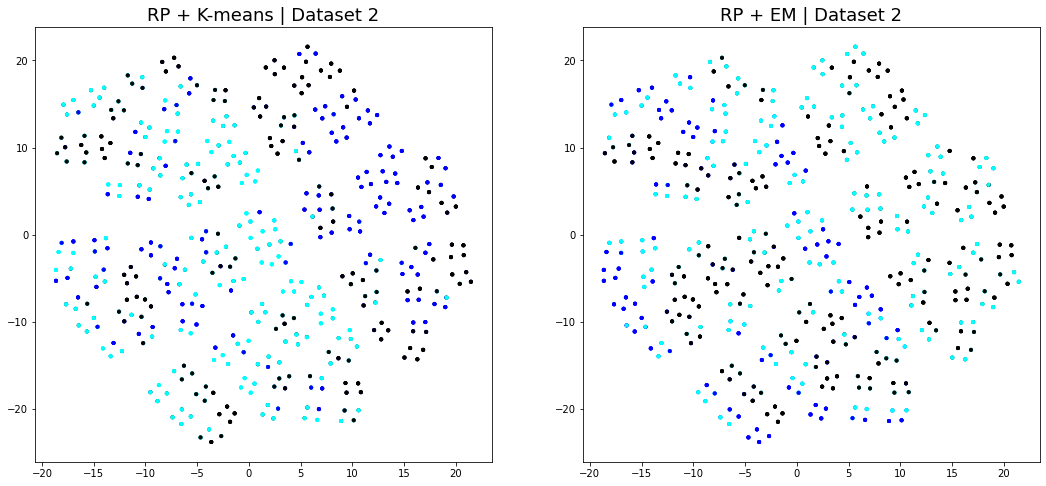

In [259]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    1:'black',
    2:'cyan',
    0:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_rca_km], cmap='inferno', marker='.')
ax1.set_title("RP + K-means | Dataset 2", {"fontsize":18})


dict_colors = {
    2:'black',
    0:'cyan',
    1:'blue'
}

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_rca_em], cmap='inferno', marker='.')
ax2.set_title("RP + EM | Dataset 2", {"fontsize":18})

plt.show()

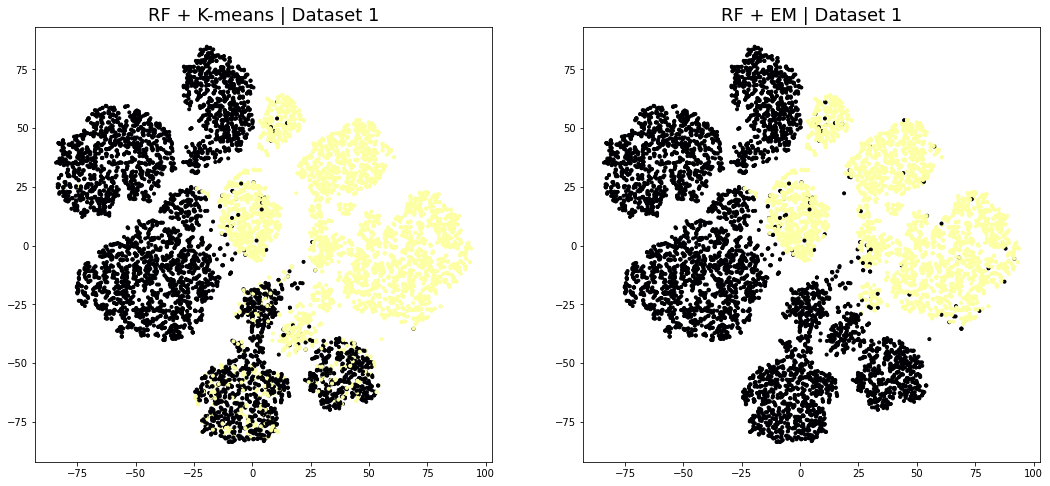

In [260]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)
if sum(labels1_rf_km) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_rf_km], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_rf_km], cmap='inferno', marker='.')
ax1.set_title("RF + K-means | Dataset 1", {"fontsize":18})

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X1)

if sum(labels1_rf_em) > 5000:
    plt.scatter(tsne[:,0],tsne[:,1], c=[1-label for label in labels1_rf_em], cmap='inferno', marker='.')
else:
    plt.scatter(tsne[:,0],tsne[:,1], c=[label for label in labels1_rf_em], cmap='inferno', marker='.')

ax2.set_title("RF + EM | Dataset 1", {"fontsize":18})

plt.show()

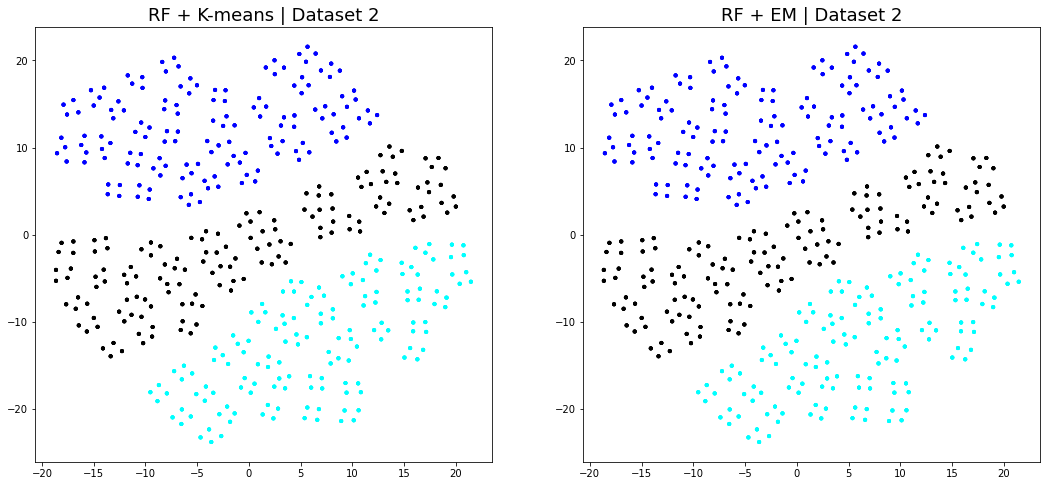

In [264]:
fig = plt.figure(figsize=(18,8))

dict_colors = {
    0:'black',
    1:'cyan',
    2:'blue'
}

ax1 = fig.add_subplot(1,2,1)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_rf_km], cmap='inferno', marker='.')
ax1.set_title("RF + K-means | Dataset 2", {"fontsize":18})


dict_colors = {
    2:'black',
    1:'cyan',
    0:'blue'
}

ax2 = fig.add_subplot(1,2,2)
tsne = TSNE(n_components=2, random_state=0).fit_transform(X2)
plt.scatter(tsne[:,0],tsne[:,1], c=[dict_colors[label] for label in labels2_rf_em], cmap='inferno', marker='.')
ax2.set_title("RF + EM | Dataset 2", {"fontsize":18})

plt.show()

## <font size="3"> Statistical curves:</font>

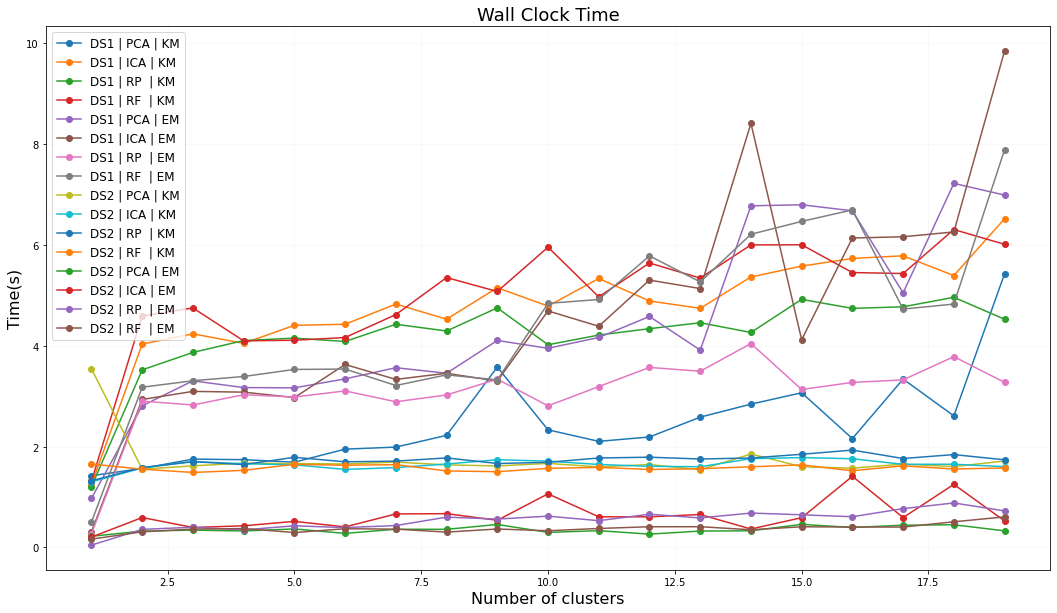

In [528]:
plt.figure(figsize=(18,10))
plt.plot(values_n_clusters, times1_pca_km, '-o', label="DS1 | PCA | KM")
plt.plot(values_n_clusters, times1_ica_km, '-o', label="DS1 | ICA | KM")
plt.plot(values_n_clusters, times1_rca_km, '-o', label="DS1 | RP  | KM")
plt.plot(values_n_clusters, times1_rf_km, '-o',  label="DS1 | RF  | KM")
plt.plot(values_n_clusters, times_1_pca_em, '-o', label="DS1 | PCA | EM")
plt.plot(values_n_clusters, times_1_ica_em, '-o', label="DS1 | ICA | EM")
plt.plot(values_n_clusters, times_1_rca_em, '-o', label="DS1 | RP  | EM")
plt.plot(values_n_clusters, times_1_rf_em, '-o', label= "DS1 | RF  | EM")

plt.plot(values_n_clusters, times2_pca_km, '-o', label="DS2 | PCA | KM")
plt.plot(values_n_clusters, times2_ica_km, '-o', label="DS2 | ICA | KM")
plt.plot(values_n_clusters, times2_rca_km, '-o', label="DS2 | RP  | KM")
plt.plot(values_n_clusters, times2_rf_km, '-o',  label="DS2 | RF  | KM")
plt.plot(values_n_clusters, times_2_pca_em, '-o', label="DS2 | PCA | EM")
plt.plot(values_n_clusters, times_2_ica_em, '-o', label="DS2 | ICA | EM")
plt.plot(values_n_clusters, times_2_rca_em, '-o', label="DS2 | RP  | EM")
plt.plot(values_n_clusters, times_2_rf_em, '-o', label= "DS2 | RF  | EM")


plt.xlabel('Number of clusters', {"fontsize":16})
plt.ylabel('Time(s)', {"fontsize":16})
plt.title("Wall Clock Time", {"fontsize":18})
plt.grid(linestyle='-', alpha=0.1)
plt.legend(fontsize=12)
plt.show()

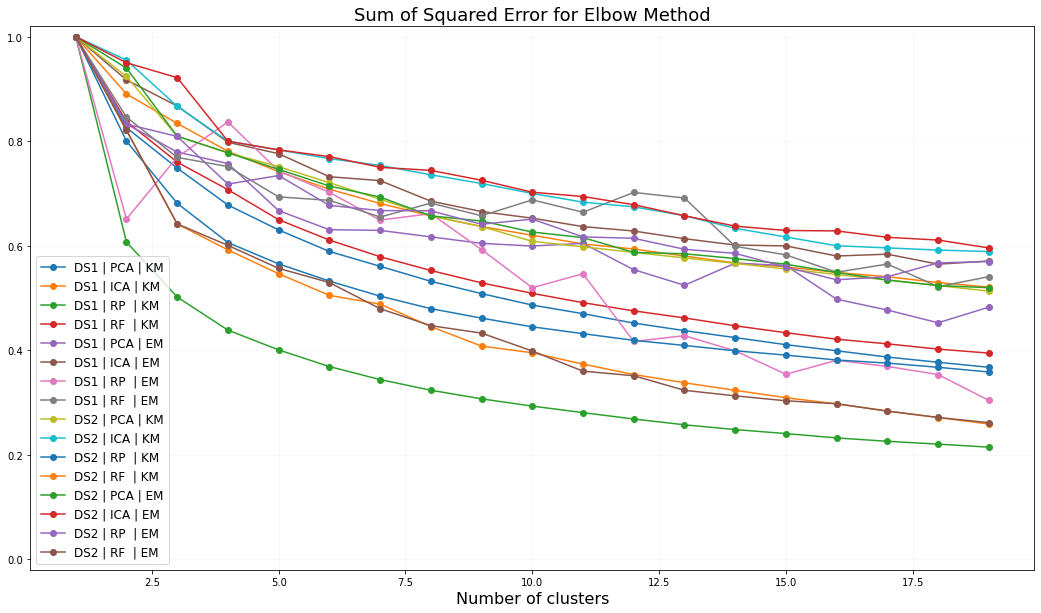

In [286]:
plt.figure(figsize=(18,10))
plt.plot(values_n_clusters, [ssd/max(ssd_values1_pca_km) for ssd in ssd_values1_pca_km], '-o', label="DS1 | PCA | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_ica_km) for ssd in ssd_values1_ica_km], '-o', label="DS1 | ICA | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_rca_km) for ssd in ssd_values1_rca_km], '-o', label="DS1 | RP  | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_rf_km) for ssd in ssd_values1_rf_km], '-o',  label="DS1 | RF  | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_pca_em) for ssd in ssd_values1_pca_em], '-o', label="DS1 | PCA | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_ica_em) for ssd in ssd_values1_ica_em], '-o', label="DS1 | ICA | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_rca_em) for ssd in ssd_values1_rca_em], '-o', label="DS1 | RP  | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values1_rf_em) for ssd in ssd_values1_rf_em], '-o', label= "DS1 | RF  | EM")

plt.plot(values_n_clusters, [ssd/max(ssd_values2_pca_km) for ssd in ssd_values2_pca_km], '-o', label="DS2 | PCA | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_ica_km) for ssd in ssd_values2_ica_km], '-o', label="DS2 | ICA | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_rca_km) for ssd in ssd_values2_rca_km], '-o', label="DS2 | RP  | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_rf_km) for ssd in ssd_values2_rf_km], '-o',  label="DS2 | RF  | KM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_pca_em) for ssd in ssd_values2_pca_em], '-o', label="DS2 | PCA | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_ica_em) for ssd in ssd_values2_ica_em], '-o', label="DS2 | ICA | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_rca_em) for ssd in ssd_values2_rca_em], '-o', label="DS2 | RP  | EM")
plt.plot(values_n_clusters, [ssd/max(ssd_values2_rf_em) for ssd in ssd_values2_rf_em], '-o', label= "DS2 | RF  | EM")


plt.xlabel('Number of clusters', {"fontsize":16})
plt.title("Sum of Squared Error for Elbow Method", {"fontsize":18})
plt.ylim(-0.02,1.02)
plt.grid(linestyle='-', alpha=0.1)
plt.legend(fontsize=12)
plt.show()

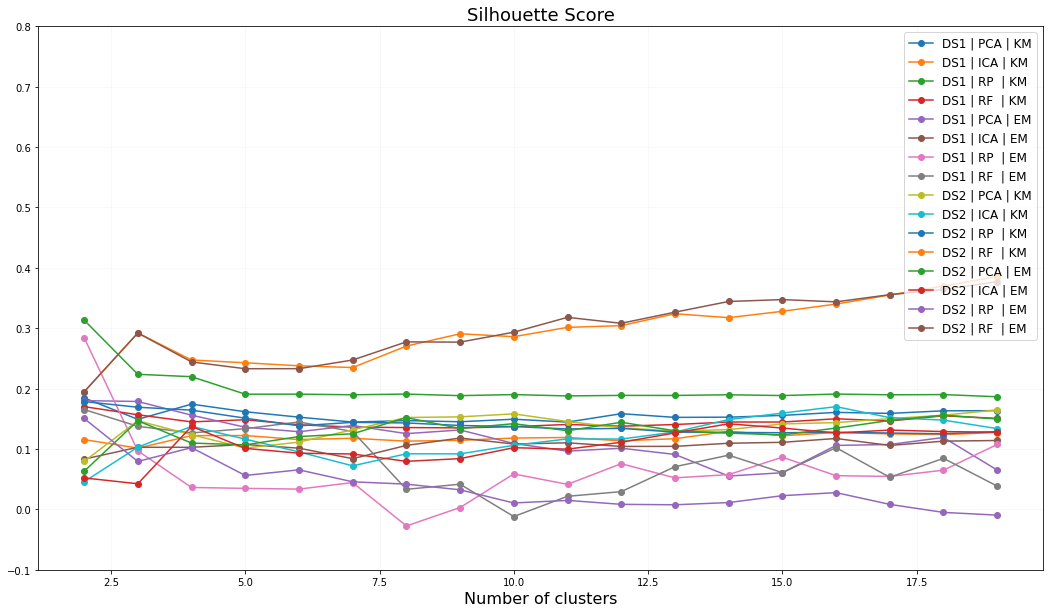

In [293]:
plt.figure(figsize=(18,10))
plt.plot(values_n_clusters[1:], sil_values1_pca_km, '-o', label="DS1 | PCA | KM")
plt.plot(values_n_clusters[1:], sil_values1_ica_km, '-o', label="DS1 | ICA | KM")
plt.plot(values_n_clusters[1:], sil_values1_rca_km, '-o', label="DS1 | RP  | KM")
plt.plot(values_n_clusters[1:], sil_values1_rf_km, '-o',  label="DS1 | RF  | KM")
plt.plot(values_n_clusters[1:], sil_values1_pca_em, '-o', label="DS1 | PCA | EM")
plt.plot(values_n_clusters[1:], sil_values1_ica_em, '-o', label="DS1 | ICA | EM")
plt.plot(values_n_clusters[1:], sil_values1_rca_em, '-o', label="DS1 | RP  | EM")
plt.plot(values_n_clusters[1:], sil_values1_rf_em, '-o', label= "DS1 | RF  | EM")

plt.plot(values_n_clusters[1:], sil_values2_pca_km, '-o', label="DS2 | PCA | KM")
plt.plot(values_n_clusters[1:], sil_values2_ica_km, '-o', label="DS2 | ICA | KM")
plt.plot(values_n_clusters[1:], sil_values2_rca_km, '-o', label="DS2 | RP  | KM")
plt.plot(values_n_clusters[1:], sil_values2_rf_km, '-o',  label="DS2 | RF  | KM")
plt.plot(values_n_clusters[1:], sil_values2_pca_em, '-o', label="DS2 | PCA | EM")
plt.plot(values_n_clusters[1:], sil_values2_ica_em, '-o', label="DS2 | ICA | EM")
plt.plot(values_n_clusters[1:], sil_values2_rca_em, '-o', label="DS2 | RP  | EM")
plt.plot(values_n_clusters[1:], sil_values2_rf_em, '-o', label= "DS2 | RF  | EM")

plt.xlabel('Number of clusters', {"fontsize":16})
plt.ylim(-0.1, 0.8)
plt.title("Silhouette Score", {"fontsize":18})
plt.grid(linestyle='-', alpha=0.1)
plt.legend(fontsize=12)
plt.show()

In [537]:
sil_values2_rf_em

[0.19463945119916198,
 0.29208606040447793,
 0.24414907628224863,
 0.23292012872874365,
 0.2329929433857045,
 0.2473274024513995,
 0.2773631273236019,
 0.276910389475143,
 0.29339935148797786,
 0.3179581243066822,
 0.30810805689240023,
 0.3265540561516617,
 0.3442331896396521,
 0.3473553798569254,
 0.3436363619564585,
 0.3555091698045609,
 0.3641010145885317,
 0.376988754596515]

<a id='6'></a>
#  Neural Network on Dataset 1 - with transformed data

## <font size="3"> Splitting training/testing:</font>

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.2, random_state = 10, stratify=Y1)

## <font size="3"> Original data:</font>

In [459]:
t = time()

nn = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01)
nn.fit(X_train, y_train.astype(int))

print("Training time:", time() - t)

test_pred = nn.predict(X_test)
train_pred =  nn.predict(X_train)

Training time: 4.016838550567627


              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1593
           1       0.66      0.46      0.54       407

    accuracy                           0.84      2000
   macro avg       0.77      0.70      0.73      2000
weighted avg       0.83      0.84      0.83      2000



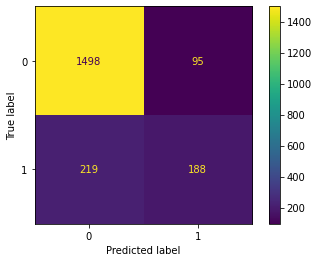

In [460]:
plot_confusion_matrix(nn, X_test, y_test.astype(int), )
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred))

In [495]:
times_origin = []
acc_origin = []
f1_origin = []

for _ in range(20):
    t = time()

    nn = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01, max_iter=100)
    nn.fit(X_train, y_train.astype(int))

    print("Training time:", time() - t)
    times_origin.append(time()-t)
    test_pred = nn.predict(X_test)
    train_pred =  nn.predict(X_train)
    acc_origin.append(balanced_accuracy_score(y_test.astype(int), test_pred))
    f1_origin.append(f1_score(y_test.astype(int), test_pred))

print("Mean time", np.mean(times_origin))
print("Mean Balanced Accuracy", np.mean(acc_origin))
print("Mean F1-score", np.mean(f1_origin))

Training time: 5.276806354522705


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 6.491559982299805
Training time: 4.5082688331604
Training time: 4.658699989318848
Training time: 4.586692810058594
Training time: 4.03152322769165
Training time: 4.398812770843506
Training time: 5.049670696258545
Training time: 4.618995904922485
Training time: 4.985379695892334
Training time: 4.036046981811523
Training time: 5.3038036823272705
Training time: 6.086353540420532
Training time: 4.327267169952393
Training time: 4.111772537231445
Training time: 3.894338846206665
Training time: 4.905487775802612
Training time: 4.445833921432495
Training time: 5.0820159912109375
Training time: 4.7021849155426025
Mean time 4.7751784205436705
Mean Balanced Accuracy 0.7121981380455956
Mean F1-score 0.5632441742332641


## <font size="3"> PCA:</font>

In [461]:
pca = PCA(6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

t = time()

nn_pca = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01)
nn_pca.fit(X_train_pca, y_train.astype(int))

print("Training time:", time() - t)

test_pred_pca = nn_pca.predict(X_test_pca)
train_pred_pca =  nn_pca.predict(X_train_pca)

Training time: 3.1839983463287354


              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1593
           1       0.65      0.43      0.52       407

    accuracy                           0.84      2000
   macro avg       0.76      0.68      0.71      2000
weighted avg       0.82      0.84      0.82      2000



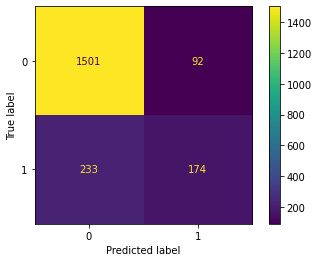

In [462]:
plot_confusion_matrix(nn_pca, X_test_pca, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_pca))

In [499]:
times_pca = []
acc_pca = []
f1_pca = []

for _ in range(20):
    t = time()

    nn_pca = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01, max_iter=100)
    nn_pca.fit(X_train_pca, y_train.astype(int))

    print("Training time:", time() - t)
    times_pca.append(time()-t)
    test_pred_pca = nn_pca.predict(X_test_pca)
    acc_pca.append(balanced_accuracy_score(y_test.astype(int), test_pred_pca))
    f1_pca.append(f1_score(y_test.astype(int), test_pred_pca))

print("Mean time", np.mean(times_pca))
print("Mean Balanced Accuracy", np.mean(acc_pca))
print("Mean F1-score", np.mean(f1_pca))

Training time: 2.728421211242676


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.5858755111694336


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.5736355781555176


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.7820522785186768
Training time: 2.312396287918091


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.542137622833252


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.161250114440918


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.35827374458313


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.4764552116394043


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.788647174835205


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.681960105895996


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.7310216426849365


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.576786994934082


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.7953274250030518


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.8088345527648926


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.390169858932495


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.3901660442352295


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.5358471870422363
Training time: 3.6618881225585938
Training time: 4.010213375091553
Mean time 3.2946653723716737
Mean Balanced Accuracy 0.6877954996599064
Mean F1-score 0.5228636167901685


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## <font size="3"> ICA:</font>

In [463]:
ica = FastICA(n_components=9, random_state=0, max_iter=1000, tol=1e-4)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

t = time()

nn_ica = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01)
nn_ica.fit(X_train_ica, y_train.astype(int))

print("Training time:", time() - t)

test_pred_ica = nn_ica.predict(X_test_ica)
train_pred_ica =  nn_ica.predict(X_train_ica)

Training time: 3.1621952056884766


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



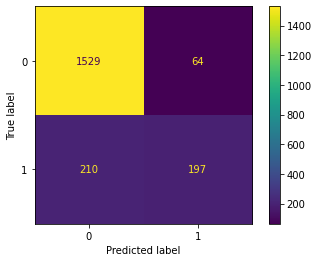

In [464]:
plot_confusion_matrix(nn_ica, X_test_ica, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_ica))

In [501]:
times_ica = []
acc_ica = []
f1_ica = []

for _ in range(20):
    t = time()

    nn_ica = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01, max_iter=100)
    nn_ica.fit(X_train_ica, y_train.astype(int))

    print("Training time:", time() - t)
    times_ica.append(time()-t)
    test_pred_ica = nn_ica.predict(X_test_ica)
    acc_ica.append(balanced_accuracy_score(y_test.astype(int), test_pred_ica))
    f1_ica.append(f1_score(y_test.astype(int), test_pred_ica))

print("Mean time", np.mean(times_ica))
print("Mean Balanced Accuracy", np.mean(acc_ica))
print("Mean F1-score", np.mean(f1_ica))

/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.115800619125366
Training time: 2.534301996231079


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.2013556957244873
Training time: 2.4894046783447266


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.6514410972595215
Training time: 2.9888486862182617


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.8235926628112793
Training time: 2.5401077270507812


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.552454710006714
Training time: 0.6451761722564697
Training time: 3.2446019649505615


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.5627615451812744
Training time: 3.0667083263397217


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.2768404483795166


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.225400924682617
Training time: 1.9823944568634033


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.343881845474243
Training time: 3.427823781967163
Training time: 3.146523952484131
Training time: 3.0249743461608887
Mean time 2.8923344135284426
Mean Balanced Accuracy 0.6882039589666709
Mean F1-score 0.5218435379909065


## <font size="3"> RP:</font>

In [469]:
rca = GaussianRandomProjection(n_components=5)
X_train_rca = rca.fit_transform(X_train)
X_test_rca = rca.transform(X_test)

t = time()
nn_rca = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01)
nn_rca.fit(X_train_rca, y_train.astype(int))

print("Training time:", time() - t)

test_pred_rca = nn_rca.predict(X_test_rca)
train_pred_rca =  nn_rca.predict(X_train_rca)

Training time: 4.74552583694458


              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1593
           1       0.60      0.33      0.43       407

    accuracy                           0.82      2000
   macro avg       0.72      0.64      0.66      2000
weighted avg       0.80      0.82      0.80      2000



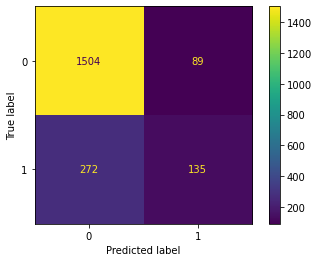

In [470]:
plot_confusion_matrix(nn_rca, X_test_rca, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_rca))

In [502]:
times_rca = []
acc_rca = []
f1_rca = []

for _ in range(20):
    t = time()

    nn_rca = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01, max_iter=100)
    nn_rca.fit(X_train_rca, y_train.astype(int))

    print("Training time:", time() - t)
    times_rca.append(time()-t)
    test_pred_rca = nn_rca.predict(X_test_rca)
    acc_rca.append(balanced_accuracy_score(y_test.astype(int), test_pred_rca))
    f1_rca.append(f1_score(y_test.astype(int), test_pred_rca))

print("Mean time", np.mean(times_rca))
print("Mean Balanced Accuracy", np.mean(acc_rca))
print("Mean F1-score", np.mean(f1_rca))

/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.860600709915161


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.0970396995544434


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.205065965652466


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.1847095489501953


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.9247844219207764


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 2.712584972381592
Training time: 2.1662485599517822


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.419309139251709


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.423668146133423


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.333777904510498
Training time: 3.298671007156372


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.486659526824951


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.3912513256073


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.706892728805542


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.891258478164673


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.9234848022460938


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.5649731159210205


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.3459372520446777


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 3.500800609588623
Training time: 3.44922137260437
Mean time 3.2944782733917237
Mean Balanced Accuracy 0.6252468955858786
Mean F1-score 0.400882182579479


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## <font size="3"> RF:</font>

In [485]:
X_train_rf = X_train[:, indices1[importance1[indices1]>0.05]]
X_test_rf = X_test[:, indices1[importance1[indices1]>0.05]]

t = time()
nn_rf = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01)
nn_rf.fit(X_train_rf, y_train.astype(int))

print("Training time:", time() - t)

test_pred_rf = nn_rf.predict(X_test_rf)
train_pred_rf =  nn_rf.predict(X_train_rf)

Training time: 3.780271053314209


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1593
           1       0.61      0.45      0.52       407

    accuracy                           0.83      2000
   macro avg       0.74      0.69      0.71      2000
weighted avg       0.82      0.83      0.82      2000



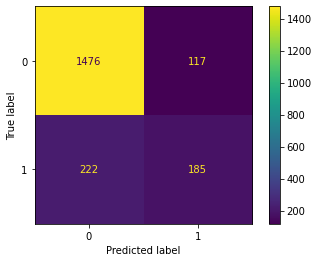

In [486]:
plot_confusion_matrix(nn_rf, X_test_rf, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_rf))

In [513]:
times_rf = []
acc_rf = []
f1_rf = []

for i in range(20):
    t = time()

    nn_rf = MLPClassifier((32,16,8),'relu', learning_rate_init=0.01, max_iter=100)
    nn_rf.fit(X_train_rf, y_train.astype(int))
    print("Training time:", time() - t)
    times_rf.append(time()-t)
    test_pred_rf = nn_rf.predict(X_test_rf)
    acc_rf.append(balanced_accuracy_score(y_test.astype(int), test_pred_rf))
    f1_rf.append(f1_score(y_test.astype(int), test_pred_rf))

print("Mean time", np.mean(times_rf))
print("Mean Balanced Accuracy", np.mean(acc_rf))
print("Mean F1-score", np.mean(f1_rf))

Training time: 3.3304765224456787
Training time: 2.9251675605773926
Training time: 3.0898845195770264
Training time: 3.0945005416870117
Training time: 3.334338665008545


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 4.006675481796265


/home/amine/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training time: 4.0754148960113525
Training time: 3.9812614917755127
Training time: 4.3166117668151855
Training time: 4.052960395812988
Training time: 4.293802976608276
Training time: 4.03302526473999
Training time: 4.00888991355896
Training time: 4.018089771270752
Training time: 4.368903636932373
Training time: 3.966841697692871
Training time: 4.16385293006897
Training time: 4.011213302612305
Training time: 4.024033546447754
Training time: 4.231055021286011
Mean time 3.866349995136261
Mean Balanced Accuracy 0.6958207437020996
Mean F1-score 0.5381513442118585


<a id='6'></a>
#  Neural Network on Dataset 1 - with clustering labels

## <font size="3"> K-means:</font>

In [574]:
km = KMeans(n_clusters=18)

X_train_km = km.fit_predict(X_train).reshape(-1,1)
X_test_km = km.predict(X_test).reshape(-1,1)

t = time()
nn_km = MLPClassifier((32, 16, 8),'relu', learning_rate_init=0.01)
nn_km.fit(X_train_km, y_train.astype(int))

print("Training time:", time() - t)

test_pred_km = nn_km.predict(X_test_km)
train_pred_km =  nn_km.predict(X_train_km)

Training time: 3.2447097301483154


              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1593
           1       0.56      0.08      0.13       407

    accuracy                           0.80      2000
   macro avg       0.69      0.53      0.51      2000
weighted avg       0.76      0.80      0.73      2000



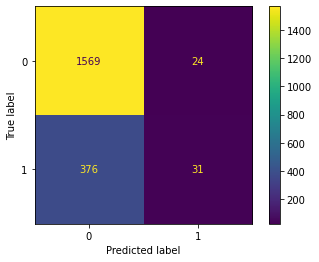

In [575]:
plot_confusion_matrix(nn_km, X_test_km, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_km))

## <font size="3"> Expectation Maximization:</font>

In [584]:
em = GaussianMixture(n_components=38, random_state=0)

X_train_em = em.fit_predict(X_train).reshape(-1,1)
X_test_em = em.predict(X_test).reshape(-1,1)

t = time()
nn_em = MLPClassifier((32,32,32),'relu', learning_rate_init=0.01)
nn_em.fit(X_train_em, y_train.astype(int))

print("Training time:", time() - t)

test_pred_em = nn_em.predict(X_test_em)
train_pred_em =  nn_em.predict(X_train_em)

Training time: 3.0716843605041504


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.60      0.01      0.01       407

    accuracy                           0.80      2000
   macro avg       0.70      0.50      0.45      2000
weighted avg       0.76      0.80      0.71      2000



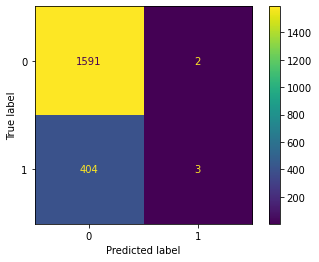

In [585]:
plot_confusion_matrix(nn_em, X_test_em, y_test.astype(int))
print(classification_report(y_true=y_test.astype(int), y_pred=test_pred_em))